In [50]:
import sys
# Append root path 
sys.path.append("../")

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
import time

os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

if tf.test.gpu_device_name() != '/device:GPU:0':
    print('WARNING: GPU device not found.')
else:
    print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

from model.mixed_effects import *

from vis.utils.utils import apply_modifications
# helper function
def update_layer_activation(model, activation, index=-1):
    model.layers[index].activation = activation
    return apply_modifications(model)

from utils.fe_models import get_model
from utils.evaluation import *
from utils.utils import *
from utils.utils import TargetEncoderMultiClass

# from lmmnn.utils import generate_data
from utils.simchoni_utils_multiclass import generate_data as generate_categorical_data

from tensorflow.keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Reshape, Embedding, Concatenate
from tensorflow.keras.activations import sigmoid

from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import roc_auc_score as auroc
from sklearn.metrics import f1_score as f1
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder

# from tqdm import tqdm
from scipy import stats
import yaml
import gc

RS = 555

SUCCESS: Found GPU: /device:GPU:0


In [2]:
experiment_name = "aaai_simulated_multiclass"
if not os.path.exists(f"../results/{experiment_name}"):
    os.mkdir(f"../results/{experiment_name}")
    

In [3]:
iterations = 5
mode = "glmm"

scenarios = {
    "base": {
        "N": 100000,
        "d": 10,
        "n_classes": 5,
        "qs": [1000, 10, 1000],
        "sig2bs": [[0.0001,0.0001,0.0001,0.0001,0.0001,],
                   [0.5,0.5,0.5,0.5,0.5,],
                   [0.5,0.5,0.5,0.5,0.5,]],
    },
    "1Msamples": {
        "N": 1000000,
        "d": 10,
        "n_classes": 5,
        "qs": [1000, 10, 1000],
        "sig2bs": [[0.0001,0.0001,0.0001,0.0001,0.0001,],
                   [0.5,0.5,0.5,0.5,0.5,],
                   [0.5,0.5,0.5,0.5,0.5,]],
    },
    "1000features": {
        "N": 100000,
        "d": 1000,
        "n_classes": 5,
        "qs": [1000, 10, 1000],
        "sig2bs": [[0.0001,0.0001,0.0001,0.0001,0.0001,],
                   [0.5,0.5,0.5,0.5,0.5,],
                   [0.5,0.5,0.5,0.5,0.5,]],
    },
    "100classes": {
        "N": 100000,
        "d": 10,
        "n_classes": 100,
        "qs": [1000, 10, 1000],
        "sig2bs": [[0.0001]*100,
                   [0.5]*100,
                   [0.5]*100],
    },
    "high_cardinality": {
        "N": 100000,
        "d": 10,
        "n_classes": 5,
        "qs": [20000, 20000, 20000],
        "sig2bs": [[0.0001,0.0001,0.0001,0.0001,0.0001,],
                   [0.5,0.5,0.5,0.5,0.5,],
                   [0.5,0.5,0.5,0.5,0.5,]],
    },
    "dominatRE": {
        "N": 100000,
        "d": 10,
        "n_classes": 5,
        "qs": [1000, 10, 1000],
        "sig2bs": [[5.,5.,5.,5.,5.,],
                   [0.5,0.5,0.5,0.5,0.5,],
                   [0.5,0.5,0.5,0.5,0.5,]],
    },
    "irrelevantRE": {
        "N": 100000,
        "d": 10,
        "n_classes": 5,
        "qs": [1000, 10, 1000],
        "sig2bs": [[0.0001,0.0001,0.0001,0.0001,0.0001,],
                   [0.0001,0.0001,0.0001,0.0001,0.0001,],
                   [0.0001,0.0001,0.0001,0.0001,0.0001,]],
    },    
    "class_variations": {
        "N": 100000,
        "d": 10,
        "n_classes": 5,
        "qs": [1000, 10, 1000],
        "sig2bs": [[0.0001,0.0001,0.0001,0.0001,0.0001,],
                   [0.0001,0.25,0.5,0.75,0.5,],
                   [0.0001,0.5,0.25,0.5,0.75,]],
    },   
    "10RE": {
        "N": 100000,
        "d": 10,
        "n_classes": 5,
        "qs": [1000]*10,
        "sig2bs": [[0.1]*5,
                   [0.2]*5,
                   [0.3]*5,
                   [0.4]*5,
                   [0.5]*5,
                   [0.6]*5,
                   [0.7]*5,
                   [0.8]*5,
                   [0.9]*5,
                   [1.0]*5,
                  ],
    },
}


if not os.path.exists(f"../results/{experiment_name}/datasets.pickle"):

    datasets = {}
    for scenario_key in scenarios:
        scenario = scenarios[scenario_key]

        N = scenario["N"]
        d = scenario["d"]
        n_classes = scenario["n_classes"]
        qs = scenario["qs"]
        sig2bs = scenario["sig2bs"]

        params = {
            "n_fixed_effects": d,
            "fixed_intercept": 1,
            "X_non_linear": True,
            "Z_non_linear": False,
            "Z_embed_dim_pct": 10,
            "n_per_cat": 3,
            "test_size": 0.2,
        }    

        if len(np.unique(sig2bs[0]))==1:
            class_variance = "constant"
        else:
            class_variance = "varying"

        datasets[scenario_key] = {}
        print(scenario_key)
        for num in range(iterations):
            np.random.seed(RS+num)
            datasets[scenario_key][num] = generate_categorical_data(mode=mode, qs=qs, sig2e=1, sig2bs=sig2bs, sig2bs_spatial=[], q_spatial=[], N=N, rhos=None, p_censor=None, params=params, n_classes=n_classes)

    with open(f"../results/{experiment_name}/datasets.pickle", 'wb') as handle:
        pickle.dump(datasets, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    print("Load generated datasets")
    with open(f"../results/{experiment_name}/datasets.pickle", 'rb') as handle:
        datasets = pickle.load(handle)


Load generated datasets


In [4]:
loss_use = lambda: tf.keras.losses.CategoricalCrossentropy

target= "categorical"
batch_size=100
epochs = 200
early_stopping = 5
model_name = "simchoni_2021"
embed_dims_method = "AutoGluon"

results = {}


for scenario_key in scenarios:
    scenario = scenarios[scenario_key]

    N = scenario["N"]
    d = scenario["d"]
    n_classes = scenario["n_classes"]
    qs = scenario["qs"]
    sig2bs = scenario["sig2bs"]
    
    results[scenario_key] = {}
    for num in range(iterations):
        if not os.path.exists(f"../results/{experiment_name}/results_RS{RS}_{scenario_key}_iter{num}.pickle"):

            results[scenario_key][num] = {}


            tf.random.set_seed(RS+num)
            np.random.seed(RS+num)

            print(f"Start modeling for scenario {scenario_key}, iteration={num}")
            X_train, X_test, y_train, y_test, x_cols, dist_matrix, time2measure_dict, y_before_RE, y_after_RE, b_true = datasets[scenario_key][num]

            z_cols = sorted(list(set(X_train.columns)-set(x_cols)))#[f"z{i}" for i in range(len(qs))]
            cols = X_train.columns

            X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
            X_train = pd.DataFrame(X_train,columns=cols)
            X_val = pd.DataFrame(X_val,columns=cols)

            Z_train = X_train[z_cols].values
            X_train = X_train[x_cols].astype(np.float32)
            y_train = y_train.astype(np.float32)

            Z_val = X_val[z_cols].values
            X_val = X_val[x_cols].astype(np.float32)
            y_val = y_val.astype(np.float32)

            Z_test = X_test[z_cols].values
            X_test = X_test[x_cols].astype(np.float32)
            y_test = y_test.astype(np.float32)

            qs = np.max([tf.reduce_max(Z_train, axis=0),tf.reduce_max(Z_val, axis=0),tf.reduce_max(Z_test, axis=0)],axis=0)+1
            
            # Target encoding
            start = time.time()
            encoder = TargetEncoderMultiClass(n_classes)
            z_target_encoded_train = encoder.fit_transform(Z_train.astype(object), y_train).values # fit_transform on train data
            z_target_encoded_val = encoder.transform(Z_val.astype(object), y_val).values # transform on test data
            z_target_encoded_test = encoder.transform(Z_test.astype(object), y_test).values # transform on test data
            end = time.time()
            target_encoding_time = end-start

            # OHE        
            if sum(qs)<20000:
                start = time.time()
                z_ohe_encoded_train = np.concatenate([tf.one_hot(Z_train[:,num],qs[num]).numpy() for num in range(len(qs))],axis=1)
                z_ohe_encoded_val = np.concatenate([tf.one_hot(Z_val[:,num],qs[num]).numpy() for num in range(len(qs))],axis=1)
                z_ohe_encoded_test = np.concatenate([tf.one_hot(Z_test[:,num],qs[num]).numpy() for num in range(len(qs))],axis=1)
                ohe_encoding_time = end-start
                ohe_encoding_time


            X_train = tf.convert_to_tensor(X_train)
            Z_train = tf.convert_to_tensor(Z_train,dtype=tf.int32)
            y_train = tf.convert_to_tensor(y_train)

            X_val = tf.convert_to_tensor(X_val)
            Z_val = tf.convert_to_tensor(Z_val,dtype=tf.int32)
            y_val = tf.convert_to_tensor(y_val)

            X_test = tf.convert_to_tensor(X_test)
            Z_test = tf.convert_to_tensor(Z_test,dtype=tf.int32)
            y_test = tf.convert_to_tensor(y_test)

            ##### GMENN #####
            n_classes = np.unique(y_train).shape[0]
            y_train = tf.one_hot(tf.cast(y_train,tf.int32),n_classes)
            y_val = tf.one_hot(tf.cast(y_val,tf.int32),n_classes)
            y_test = tf.one_hot(tf.cast(y_test,tf.int32),n_classes)

            d = X_train.shape[1] # columns
            n = X_train.shape[0] # rows
            num_outputs = n_classes
            perc_numeric = d/(d+Z_train.shape[1])

#             qs = np.max([tf.reduce_max(Z_train, axis=0),tf.reduce_max(Z_val, axis=0),tf.reduce_max(Z_test, axis=0)],axis=0)+1

            set_seed(RS)

            fe_model, optimizer = get_model(model_name=model_name, input_size=X_train.shape[1], 
                                              output_size=num_outputs, 
                                              target=target, 
                                              perc_numeric=perc_numeric, RS=RS)

            initial_stds = np.ones([len(qs),num_outputs]).astype(float).tolist()

            me_model = MixedEffectsNetwork(X_train, Z_train, y_train, fe_model, 
                                           target=target, qs=qs,
                                           initial_stds=initial_stds,
                                          fe_loss_weight=1.,
                                           mode="intercepts",
                                           early_stopping_fe=early_stopping,
                                          )    

            me_model.compile(
                loss_class_me = loss_use()(),
                loss_class_fe = loss_use()(),
            #     metric_class_me = tf.keras.metrics.AUC(multi_label=True, name="auc_me"),
            #     metric_class_fe = tf.keras.metrics.AUC(multi_label=True, name="auc_fe"),
                optimizer=optimizer
            )

            mcmc = MCMCSamplingCallback(num_mcmc_samples=1,
                                        perc_burnin=0.7,
                                        warm_restart=None,
                                        num_burnin_steps=1,
                                        step_size = 0.1#initial_step_size,
                                   )

            print_metric = PrintMetrics(X_train, Z_train, y_train, X_val, Z_val, y_val)

            start = time.time()
            history = me_model.fit([X_train,Z_train], y_train,
                         callbacks=[mcmc,
                                    print_metric,
                                    tf.keras.callbacks.EarlyStopping(monitor="me_auc_val", patience=early_stopping, mode="max")],
                         epochs=epochs,
                         validation_data=[[X_val,Z_val],y_val],
                        batch_size=batch_size)

            end = time.time()
            fit_time_gmenn = round(end-start,2)

            y_train_pred_gmenn, y_train_pred_gmenn_fe = me_model([X_train,Z_train])
            y_val_pred_gmenn, y_val_pred_gmenn_fe = me_model([X_val,Z_val])
            y_test_pred_gmenn, y_test_pred_gmenn_fe = me_model([X_test,Z_test])    

            gc.collect()
            ##### Ignore #####
            metrics_use = []
            metrics_use.append(tf.keras.metrics.AUC(multi_label=True, name="auc"))
            metrics_use.append(tf.keras.metrics.CategoricalAccuracy(name="accuracy"))
            metrics_use.append(F1Score(num_classes=num_outputs, average="weighted", name="f1"))
            stop_mode = "max"
            activation_layer = tf.keras.activations.softmax

            model_nn, optimizer = get_model(model_name=model_name, 
                                            input_size=X_train.shape[1], 
                                            output_size=num_outputs, 
                                            target=target, 
                                            perc_numeric=perc_numeric, RS=RS)
            model_nn.build((n,d))
            update_layer_activation(model=model_nn, activation=activation_layer)

            model_nn.compile(loss=loss_use()(), optimizer=optimizer, metrics = metrics_use)

            callback = tf.keras.callbacks.EarlyStopping(monitor="val_auc", patience=early_stopping, mode=stop_mode)

            start = time.time()
            history_nn = model_nn.fit(X_train, y_train,
                         validation_data= [X_val, y_val],
                         epochs=epochs, batch_size=batch_size, callbacks=[callback])
            end = time.time()
            fit_time_nn = round(end-start,2)

            y_train_pred_nn = model_nn.predict(X_train ,batch_size=batch_size)
            y_val_pred_nn = model_nn.predict(X_val ,batch_size=batch_size)
            y_test_pred_nn = model_nn.predict(X_test ,batch_size=batch_size)

            eval_res_train_nn = get_metrics(y_train, y_train_pred_nn, target=target)
            eval_res_val_nn = get_metrics(y_val, y_val_pred_nn, target=target)
            eval_res_test_nn = get_metrics(y_test, y_test_pred_nn, target=target)

            gc.collect()
            ##### Target Encoding #####
            print("\n Train Target Encoding Network")
            X_train_te = np.append(X_train ,z_target_encoded_train, axis=1)
            X_val_te = np.append(X_val ,z_target_encoded_val, axis=1)
            X_test_te = np.append(X_test ,z_target_encoded_test, axis=1)

            metrics_use = []
            metrics_use.append(tf.keras.metrics.AUC(multi_label=True, name="auc"))
            metrics_use.append(tf.keras.metrics.CategoricalAccuracy(name="accuracy"))
            metrics_use.append(F1Score(num_classes=num_outputs, average="weighted", name="f1"))
            stop_mode = "max"
            activation_layer = tf.keras.activations.softmax

            model_nn_te, optimizer = get_model(model_name=model_name, 
                                            input_size=X_train_te.shape[1], 
                                            output_size=num_outputs, 
                                            target=target, 
                                            perc_numeric=perc_numeric, RS=RS)
            model_nn_te.build((n,X_train_te.shape[1]))
            update_layer_activation(model=model_nn_te, activation=activation_layer)
            model_nn_te.compile(loss=loss_use()(), optimizer=optimizer, metrics = metrics_use)
            callback = tf.keras.callbacks.EarlyStopping(monitor="val_auc", patience=early_stopping, mode=stop_mode)

            start = time.time()
            history_nn_te = model_nn_te.fit(X_train_te, y_train,
                         validation_data= [X_val_te, y_val],
                         epochs=epochs, batch_size=batch_size, callbacks=[callback])
            end = time.time()
            fit_time_te = round(end-start,2)+target_encoding_time

            y_train_pred_nn_te = model_nn_te.predict(X_train_te ,batch_size=batch_size)
            y_val_pred_nn_te = model_nn_te.predict(X_val_te ,batch_size=batch_size)
            y_test_pred_nn_te = model_nn_te.predict(X_test_te ,batch_size=batch_size)

            eval_res_train_nn_te = get_metrics(y_train, y_train_pred_nn_te, target=target)
            eval_res_val_nn_te = get_metrics(y_val, y_val_pred_nn_te, target=target)
            eval_res_test_nn_te = get_metrics(y_test, y_test_pred_nn_te, target=target)

            eval_res_test_nn_te

            gc.collect()

            ##### OHE #####
            if sum(qs)<20000:
                print("\n Train OHE Network")
                X_train_ohe = np.append(X_train ,z_ohe_encoded_train, axis=1)
                X_val_ohe = np.append(X_val ,z_ohe_encoded_val, axis=1)
                X_test_ohe = np.append(X_test ,z_ohe_encoded_test, axis=1)

                metrics_use = []
                metrics_use.append(tf.keras.metrics.AUC(multi_label=True, name="auc"))
                metrics_use.append(tf.keras.metrics.CategoricalAccuracy(name="accuracy"))
                metrics_use.append(F1Score(num_classes=num_outputs, average="weighted", name="f1"))
                stop_mode = "max"
                activation_layer = tf.keras.activations.softmax

                model_nn_ohe, optimizer = get_model(model_name=model_name, 
                                                input_size=X_train_ohe.shape[1], 
                                                output_size=num_outputs, 
                                                target=target, 
                                                perc_numeric=perc_numeric, RS=RS)
                model_nn_ohe.build((n,X_train_ohe.shape[1]))
                update_layer_activation(model=model_nn_ohe, activation=activation_layer)
                model_nn_ohe.compile(loss=loss_use()(), optimizer=optimizer, metrics = metrics_use)
                callback = tf.keras.callbacks.EarlyStopping(monitor="val_auc", patience=early_stopping, mode=stop_mode)

                start = time.time()
                history_nn_ohe = model_nn_ohe.fit(X_train_ohe, y_train,
                             validation_data= [X_val_ohe, y_val],
                             epochs=epochs, batch_size=batch_size, callbacks=[callback])
                end = time.time()
                fit_time_ohe = round(end-start,2)+ohe_encoding_time
                gc.collect()
                y_train_pred_nn_ohe = model_nn_ohe.predict(X_train_ohe, batch_size=batch_size)
                y_val_pred_nn_ohe = model_nn_ohe.predict(X_val_ohe, batch_size=batch_size)
                y_test_pred_nn_ohe = model_nn_ohe.predict(X_test_ohe, batch_size=batch_size)

                eval_res_train_nn_ohe = get_metrics(y_train, y_train_pred_nn_ohe, target=target)
                eval_res_val_nn_ohe = get_metrics(y_val, y_val_pred_nn_ohe, target=target)
                eval_res_test_nn_ohe = get_metrics(y_test, y_test_pred_nn_ohe, target=target)
            else:
                print(f"Don't train OHE as total cardinality is >20k ({sum(qs)})")
                class history_nn_ohe: 
                    def __init__(self): 
                        self.history = None
                history_nn_ohe = history_nn_ohe()
                y_train_pred_nn_ohe = None
                y_val_pred_nn_ohe = None
                y_test_pred_nn_ohe = None
                fit_time_ohe = None
                
            gc.collect()
            ##### Embedding #####
            print("\n Embedding Estimate Network")
            metrics_use = []
            metrics_use.append(tf.keras.metrics.AUC(multi_label=True, name="auc"))
            metrics_use.append(tf.keras.metrics.CategoricalAccuracy(name="accuracy"))
            metrics_use.append(F1Score(num_classes=num_outputs, average="weighted", name="f1"))

            if embed_dims_method=="sqrt":
                embed_dims = [int(np.sqrt(q)) for q in qs]
            elif embed_dims_method=="AutoGluon":
                embed_dims = [int(np.max([100, np.round(1.6*q**0.56)])) for q in qs]
            else:
                embed_dims = [10 for q in qs]

            input_layer = Input(shape=(d,))

            # Define embedding layers
            embed_inputs = []
            embedding_layers = []
            for q_num in range(len(qs)):
                Z_input_layer = Input(shape=(1,))
                embedding_layer = Embedding(qs[q_num], embed_dims[q_num], input_length=1)(Z_input_layer)
                embedding_layer = Reshape(target_shape=(embed_dims[q_num],))(embedding_layer)

                embed_inputs.append(Z_input_layer)
                embedding_layers.append(embedding_layer)

            ### Get model layer dimensions
            min_numeric_embed_dim = 32
            max_numeric_embed_dim = 2056
            max_layer_width = 2056
            # Main dense model
            if target == "continuous":
                default_layer_sizes = [256,
                                       128]  # overall network will have 4 layers. Input layer, 256-unit hidden layer, 128-unit hidden layer, output layer.
            else:
                default_sizes = [256, 128]  # will be scaled adaptively
                # base_size = max(1, min(num_net_outputs, 20)/2.0) # scale layer width based on number of classes
                base_size = max(1, min(num_outputs,
                                       100) / 50)  # TODO: Updated because it improved model quality and made training far faster
                default_layer_sizes = [defaultsize * base_size for defaultsize in default_sizes]
            layer_expansion_factor = 1  # TODO: consider scaling based on num_rows, eg: layer_expansion_factor = 2-np.exp(-max(0,train_dataset.num_examples-10000))
            first_layer_width = int(min(max_layer_width, layer_expansion_factor * default_layer_sizes[0]))

            # numeric embed dim
            vector_dim = 0  # total dimensionality of vector features (I think those should be transformed string features, which we don't have)
            prop_vector_features = perc_numeric  # Fraction of features that are numeric
            numeric_embedding_size = int(min(max_numeric_embed_dim,
                                             max(min_numeric_embed_dim,
                                                 first_layer_width * prop_vector_features * np.log10(vector_dim + 10))))


            numeric_embedding = Dense(numeric_embedding_size, activation="relu")(input_layer)

            concat = Concatenate()([numeric_embedding] + embedding_layers)

            base_model, optimizer = get_model(model_name=model_name, 
                                              input_size=numeric_embedding_size + sum(embed_dims), 
                                              output_size=num_outputs, target=target,
                                              perc_numeric=perc_numeric, RS=RS)

            base_model.build((n, numeric_embedding_size + sum(embed_dims)))
            update_layer_activation(model=base_model, activation=activation_layer)

            layers = base_model(concat)

            model_embed = Model(inputs=[input_layer] + embed_inputs, outputs=layers)


            model_embed.compile(loss=loss_use()(), optimizer=optimizer, metrics = metrics_use)
            callback = tf.keras.callbacks.EarlyStopping(monitor="val_auc", patience=early_stopping, mode=stop_mode)

            start = time.time()
            history_nn_embed = model_embed.fit([X_train] + [Z_train[: ,q_num] for q_num in range(len(qs))], y_train,
                            validation_data=[[X_val] + [Z_val[: ,q_num] for q_num in range(len(qs))], y_val],
                            epochs=epochs, batch_size=batch_size, callbacks=[callback])
            end = time.time()
            fit_time_embed = round(end-start,2)

            y_train_pred_embed = model_embed.predict([X_train] + [Z_train[: ,q_num] for q_num in range(len(qs))]
                                                     ,batch_size=batch_size)
            y_val_pred_embed = model_embed.predict([X_val] + [Z_val[: ,q_num] for q_num in range(len(qs))]
                                                    ,batch_size=batch_size)
            y_test_pred_embed = model_embed.predict([X_test] + [Z_test[: ,q_num] for q_num in range(len(qs))]
                                                    ,batch_size=batch_size)

            eval_res_train_embed = get_metrics(y_train, y_train_pred_embed, target=target)
            eval_res_val_embed = get_metrics(y_val, y_val_pred_embed, target=target)
            eval_res_test_embed = get_metrics(y_test, y_test_pred_embed, target=target)

            eval_res_train_embed, eval_res_test_embed        
            gc.collect()
            
            results[scenario_key][num]["histories"] = {"GMENN": history.history,
                                                       "Ignore": history_nn.history,
                                                       "TE": history_nn_te.history,
                                                       "OHE": history_nn_ohe.history,
                                                       "Embedding": history_nn_embed.history,
                                                      }
            
            results[scenario_key][num]["predictions"] = {"GMENN": [y_train_pred_gmenn, y_val_pred_gmenn, y_test_pred_gmenn],
                                                        "GMENN (FE)": [y_train_pred_gmenn_fe, y_val_pred_gmenn_fe, y_test_pred_gmenn_fe],
                                                        "Ignore": [y_train_pred_nn, y_val_pred_nn, y_test_pred_nn],
                                                        "TE": [y_train_pred_nn_te, y_val_pred_nn_te, y_test_pred_nn_te],
                                                        "OHE": [y_train_pred_nn_ohe, y_val_pred_nn_ohe, y_test_pred_nn_ohe],
                                                        "Embedding": [y_train_pred_embed, y_val_pred_embed, y_test_pred_embed],
                                                      }
            
            results[scenario_key][num]["times"] = {"GMENN": fit_time_gmenn,
                                                   "Ignore": fit_time_nn,
                                                   "TE": fit_time_te,
                                                   "OHE": fit_time_ohe,
                                                   "Embedding": fit_time_embed,
                                                      }
            
            results[scenario_key][num]["other_info"] = {
                "GMENN": {
                    "_stddev_z": np.array([i.numpy() for i in me_model.data_model._stddev_z]),
                    "acceptance_rates": np.array(me_model.acceptance_rates),
                    "random_effects": me_model.mean_samples,
                    "all_samples": me_model.all_samples,
                    "stds": me_model.stds
                }
            }
            
            
            with open(f"../results/{experiment_name}/results_RS{RS}_{scenario_key}_iter{num}.pickle", 'wb') as handle:
                pickle.dump(results[scenario_key][num], handle, protocol=pickle.HIGHEST_PROTOCOL)
            

            del X_train, X_val, X_test, y_train, y_val, y_test
            del z_target_encoded_train, z_target_encoded_val, z_target_encoded_test
            if sum(qs)<20000:
                del z_ohe_encoded_train, z_ohe_encoded_val, z_ohe_encoded_test


            gc.collect()
        else:
            print(f"Load results for scenario {scenario_key}, iteration={num}")
            with open(f"../results/{experiment_name}/results_RS{RS}_{scenario_key}_iter{num}.pickle", 'rb') as handle:
                results[scenario_key][num] = pickle.load(handle)
            

Load results for scenario base, iteration=0
Load results for scenario base, iteration=1
Load results for scenario base, iteration=2
Load results for scenario base, iteration=3
Load results for scenario base, iteration=4
Load results for scenario 1Msamples, iteration=0
Load results for scenario 1Msamples, iteration=1
Load results for scenario 1Msamples, iteration=2
Load results for scenario 1Msamples, iteration=3
Load results for scenario 1Msamples, iteration=4
Load results for scenario 1000features, iteration=0
Load results for scenario 1000features, iteration=1
Load results for scenario 1000features, iteration=2
Load results for scenario 1000features, iteration=3
Load results for scenario 1000features, iteration=4
Load results for scenario 100classes, iteration=0
Load results for scenario 100classes, iteration=1
Load results for scenario 100classes, iteration=2
Load results for scenario 100classes, iteration=3
Load results for scenario 100classes, iteration=4
Load results for scenario

## Evaluation

### Performance

In [5]:
models = ["GMENN", "TE", "OHE", "Embedding", "Ignore"]
results_perf = {scenario_key: {num: {model: {}  for model in models} for num in range(iterations)} for scenario_key in scenarios}
for scenario_key in scenarios:
    for num in range(iterations):
        for model in models:
            y_test = datasets[scenario_key][num][3]
            if model!= "LMMNN":
                n_classes = np.unique(y_test).shape[0]
                y_test = tf.one_hot(y_test,n_classes)
            y_pred = results[scenario_key][num]["predictions"][model][2]
            if scenario_key=="high_cardinality" and model == "OHE":
                results_perf[scenario_key][num][model] = {"AUROC": np.nan, "Accuracy": np.nan, "F1": np.nan}
                results_perf[scenario_key][num][model]["Time"] = np.nan
            else:
                results_perf[scenario_key][num][model] = get_metrics(y_test,y_pred,target)
                results_perf[scenario_key][num][model]["Time"] = results[scenario_key][num]["times"][model]

In [6]:
models = ["GMENN", "TE", "OHE", "Embedding", "Ignore"]
metric = "AUROC"

#####
dataset_res_dict = {}
best_models = {}
t_test_results = {}

round_mean_at = 2
round_std_at = 3

for dataset_name in scenarios:
    dataset_models = list(results_perf[dataset_name][0].keys())
    use_df = pd.DataFrame([pd.DataFrame(results_perf[dataset_name][fold_num]).loc[metric,models] for fold_num in results_perf[dataset_name].keys()],index=results_perf[dataset_name].keys())
    
    df_mean = pd.DataFrame(use_df.mean(axis=0).round(round_mean_at).astype(str) + " (" + use_df.std(axis=0).round(round_std_at).astype(str) + ")").transpose()
    model_dict = {i: df_mean[i].values[0] for i in df_mean.columns}
    dataset_res_dict[dataset_name] = model_dict
    
    best_models[dataset_name] = use_df.columns[use_df.mean(axis=0).argmax()]

    t_test_res = np.array([stats.ttest_rel(use_df[best_models[dataset_name]].values, use_df[model].values)[1] if model in dataset_models else 0 for model in models]).round(3)
    t_test_res[np.isnan(t_test_res)] = 1.
    t_test_results[dataset_name] = t_test_res
    
res_df = pd.DataFrame(dataset_res_dict).transpose()
    
def negative_bold(val):
    i = np.where(val.name==np.array(models))[0][0]
    return ["font-weight: bold"  if t_test_results[dataset_name][i]>=0.05 else "" for dataset_name in val.keys()]
    # Case without transpose:
#     return ["font-weight: bold"  if t_test_results[val.name][i]>=0.05 else "" for i in range(len(val))]

# res_df.style.apply(negative_bold)
res_df

,GMENN,TE,OHE,Embedding,Ignore
base,0.77 (0.011),0.63 (0.013),0.74 (0.014),0.75 (0.014),0.62 (0.007)
1Msamples,0.78 (0.015),0.62 (0.01),0.78 (0.015),0.78 (0.014),0.63 (0.01)
1000features,0.55 (0.012),0.5 (0.003),0.52 (0.008),0.52 (0.003),0.5 (0.003)
100classes,0.71 (0.004),0.52 (0.011),0.63 (0.006),0.64 (0.013),0.58 (0.003)
high_cardinality,0.61 (0.011),0.56 (0.013),nan (nan),0.59 (0.004),0.62 (0.004)
dominatRE,0.91 (0.002),0.58 (0.021),0.9 (0.002),0.91 (0.002),0.58 (0.006)
irrelevantRE,0.64 (0.007),0.64 (0.009),0.6 (0.007),0.61 (0.006),0.65 (0.006)
class_variations,0.75 (0.012),0.63 (0.008),0.72 (0.01),0.73 (0.011),0.63 (0.007)
10RE,0.9 (0.001),0.55 (0.011),0.88 (0.002),0.89 (0.002),0.58 (0.005)


In [7]:
res_df.apply(negative_bold)

,GMENN,TE,OHE,Embedding,Ignore
base,font-weight: bold,,,,
1Msamples,font-weight: bold,,,,
1000features,font-weight: bold,,,,
100classes,font-weight: bold,,,,
high_cardinality,font-weight: bold,,font-weight: bold,,font-weight: bold
dominatRE,font-weight: bold,,,,
irrelevantRE,,font-weight: bold,,,font-weight: bold
class_variations,font-weight: bold,,,,
10RE,font-weight: bold,,,,


In [8]:
# add fat due to t-test: highcard-GMENN/Embed, irrelevantRE-TE | 1.0&10K-GMENN/
# non-fat due to t-test: 1M-OHE/Embed, dominantRE-Embed | 0.1&1000-TE, 0.1&10KGMENN, 1.0&100LMMNN, 1.0&1000LMMNN, 1.0&10K-GMENN

In [9]:
print(res_df.to_latex(index=True))


\begin{tabular}{llllll}
\toprule
{} &         GMENN &            TE &           OHE &     Embedding &        Ignore \\
\midrule
base             &  0.77 (0.011) &  0.63 (0.013) &  0.74 (0.014) &  0.75 (0.014) &  0.62 (0.007) \\
1Msamples        &  0.78 (0.015) &   0.62 (0.01) &  0.78 (0.015) &  0.78 (0.014) &   0.63 (0.01) \\
1000features     &  0.55 (0.012) &   0.5 (0.003) &  0.52 (0.008) &  0.52 (0.003) &   0.5 (0.003) \\
100classes       &  0.71 (0.004) &  0.52 (0.011) &  0.63 (0.006) &  0.64 (0.013) &  0.58 (0.003) \\
high\_cardinality &  0.61 (0.011) &  0.56 (0.013) &     nan (nan) &  0.59 (0.004) &  0.62 (0.004) \\
dominatRE        &  0.91 (0.002) &  0.58 (0.021) &   0.9 (0.002) &  0.91 (0.002) &  0.58 (0.006) \\
irrelevantRE     &  0.64 (0.007) &  0.64 (0.009) &   0.6 (0.007) &  0.61 (0.006) &  0.65 (0.006) \\
class\_variations &  0.75 (0.012) &  0.63 (0.008) &   0.72 (0.01) &  0.73 (0.011) &  0.63 (0.007) \\
10RE             &   0.9 (0.001) &  0.55 (0.011) &  0.88 (0.002) &  0.

<ipython-input-9-f652a012a1fe>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(res_df.to_latex(index=True))


In [10]:
dataset_df = {}
for dataset_name in scenarios:
    dataset_models = list(results_perf[dataset_name][0].keys())
    use_df = pd.DataFrame([pd.DataFrame(results_perf[dataset_name][fold_num]).loc[metric,models] for fold_num in results_perf[dataset_name].keys()],index=results_perf[dataset_name].keys())
    dataset_df[dataset_name] = use_df
    
mean_df = pd.DataFrame({dataset_name: dataset_df[dataset_name].mean(axis=0) for dataset_name in scenarios})

# Mean reciprocal rank
print(np.mean((1/mean_df.rank(axis=0,ascending=False)),axis=1).round(2))

# Mean rank
print(np.mean((mean_df.rank(axis=0,ascending=False)),axis=1).round(2))

# Average distance to best
# print(mean_df.apply(lambda x: np.abs(x-np.max(x)),axis=0).mean(axis=1).round(4))
print(mean_df.apply(lambda x: ((np.max(x)-x)/np.max(x)),axis=0).mean(axis=1).round(4))
print(mean_df.apply(lambda x: (100*(np.max(x)-x)/np.max(x)),axis=0).mean(axis=1).round(4))

mean_df

GMENN        0.87
TE           0.26
OHE          0.34
Embedding    0.44
Ignore       0.40
dtype: float64
GMENN        1.33
TE           4.22
OHE          3.12
Embedding    2.44
Ignore       3.67
dtype: float64
GMENN        0.0023
TE           0.1956
OHE          0.0473
Embedding    0.0365
Ignore       0.1713
dtype: float64
GMENN         0.2289
TE           19.5604
OHE           4.7310
Embedding     3.6463
Ignore       17.1332
dtype: float64


,base,1Msamples,1000features,100classes,high_cardinality,dominatRE,irrelevantRE,class_variations,10RE
GMENN,0.770927,0.784481,0.553588,0.705109,0.612188,0.913595,0.641792,0.749105,0.900507
TE,0.632445,0.616176,0.501013,0.523231,0.559912,0.577880,0.644708,0.628969,0.553584
OHE,0.735396,0.775210,0.522244,0.626147,NaN,0.897549,0.602701,0.715161,0.880427
Embedding,0.753805,0.779318,0.519429,0.637273,0.594022,0.906775,0.613589,0.729811,0.887251
Ignore,0.624779,0.628056,0.501739,0.583957,0.621096,0.575678,0.645836,0.628730,0.579052


In [11]:
rank_avgdist = pd.DataFrame([np.mean((mean_df.rank(axis=0,ascending=False)),axis=1).round(2),
              mean_df.apply(lambda x: np.abs(x-np.max(x)),axis=0).mean(axis=1).round(3)])
print(rank_avgdist.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  GMENN &     TE &    OHE &  Embedding &  Ignore \\
\midrule
0 &  1.330 &  4.220 &  3.120 &      2.440 &   3.670 \\
1 &  0.001 &  0.156 &  0.034 &      0.025 &   0.139 \\
\bottomrule
\end{tabular}



<ipython-input-11-a03747215486>:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(rank_avgdist.to_latex())


### Time

In [12]:
dataset_name = "1000features"
pd.DataFrame([pd.DataFrame(results_perf[dataset_name][fold_num]).loc[metric,models] for fold_num in results_perf[dataset_name].keys()],index=results_perf[dataset_name].keys())/60
# pd.DataFrame([pd.DataFrame(results_perf[dataset_name][fold_num]).loc["AUROC",models] for fold_num in results_perf[dataset_name].keys()],index=results_perf[dataset_name].keys())

,GMENN,TE,OHE,Embedding,Ignore
0,0.008876,0.008347,0.008582,0.008596,0.008378
1,0.009238,0.008352,0.008634,0.008654,0.008396
2,0.009373,0.008290,0.008769,0.008686,0.008284
3,0.009340,0.008423,0.008912,0.008718,0.008387
4,0.009306,0.008339,0.008623,0.008632,0.008367


In [13]:
models = ["GMENN", "TE", "OHE", "Embedding", "Ignore"]
metric = "Time"

#####
dataset_res_dict = {}
best_models = {}
t_test_results = {}

round_mean_at = 2
round_std_at = 3

for dataset_name in scenarios:
    dataset_models = list(results_perf[dataset_name][0].keys())
    use_df = pd.DataFrame([pd.DataFrame(results_perf[dataset_name][fold_num]).loc[metric,models] for fold_num in results_perf[dataset_name].keys()],index=results_perf[dataset_name].keys())/60
    
    df_mean = pd.DataFrame(use_df.mean(axis=0).round(round_mean_at).astype(str) + " (" + use_df.std(axis=0).round(round_std_at).astype(str) + ")").transpose()
    model_dict = {i: df_mean[i].values[0] for i in df_mean.columns}
    dataset_res_dict[dataset_name] = model_dict
    
    best_models[dataset_name] = use_df.columns[use_df.mean(axis=0).argmin()]

    t_test_res = np.array([stats.ttest_rel(use_df[best_models[dataset_name]].values, use_df[model].values)[1] if model in dataset_models else 0 for model in models]).round(3)
    t_test_res[np.isnan(t_test_res)] = 1.
    t_test_results[dataset_name] = t_test_res
    
res_df = pd.DataFrame(dataset_res_dict).transpose()
    
def negative_bold(val):
    i = np.where(val.name==np.array(models))[0][0]
    return ["font-weight: bold"  if t_test_results[dataset_name][i]>=0.05 else "" for dataset_name in val.keys()]
    # Case without transpose:
#     return ["font-weight: bold"  if t_test_results[val.name][i]>=0.05 else "" for i in range(len(val))]

# res_df.style.apply(negative_bold)
res_df

,GMENN,TE,OHE,Embedding,Ignore
base,2.54 (0.406),1.25 (0.218),0.96 (0.116),1.24 (0.194),2.24 (0.596)
1Msamples,40.1 (26.534),13.88 (11.332),12.28 (3.234),15.35 (4.92),17.3 (3.212)
1000features,3.2 (2.898),1.17 (0.451),1.67 (0.256),1.81 (1.681),1.91 (2.532)
100classes,18.01 (16.701),2.42 (0.505),1.74 (0.278),2.78 (0.359),3.69 (0.398)
high_cardinality,5.2 (1.864),1.02 (0.136),nan (nan),3.3 (0.441),2.12 (0.427)
dominatRE,4.88 (1.867),1.05 (0.457),1.2 (0.105),1.51 (0.232),2.1 (0.786)
irrelevantRE,9.15 (4.546),2.42 (0.917),0.98 (0.123),0.95 (0.101),3.43 (0.643)
class_variations,3.72 (0.932),1.36 (0.527),0.92 (0.057),1.16 (0.081),2.15 (0.887)
10RE,5.32 (0.427),1.53 (0.467),1.74 (0.167),2.11 (0.351),2.26 (0.552)


In [14]:
t_test_results

{'base': array([0.002, 0.075, 1.   , 0.053, 0.006]),
 '1Msamples': array([0.097, 0.75 , 1.   , 0.395, 0.07 ]),
 '1000features': array([0.174, 1.   , 0.063, 0.467, 0.522]),
 '100classes': array([0.097, 0.058, 1.   , 0.009, 0.002]),
 'high_cardinality': array([0.008, 1.   , 1.   , 0.001, 0.007]),
 'dominatRE': array([0.004, 1.   , 0.417, 0.12 , 0.011]),
 'irrelevantRE': array([0.015, 0.031, 0.791, 1.   , 0.001]),
 'class_variations': array([0.002, 0.151, 1.   , 0.001, 0.031]),
 '10RE': array([0.   , 1.   , 0.297, 0.077, 0.024])}

In [15]:
res_df.apply(negative_bold)

,GMENN,TE,OHE,Embedding,Ignore
base,,font-weight: bold,font-weight: bold,font-weight: bold,
1Msamples,font-weight: bold,font-weight: bold,font-weight: bold,font-weight: bold,font-weight: bold
1000features,font-weight: bold,font-weight: bold,font-weight: bold,font-weight: bold,font-weight: bold
100classes,font-weight: bold,font-weight: bold,font-weight: bold,,
high_cardinality,,font-weight: bold,font-weight: bold,,
dominatRE,,font-weight: bold,font-weight: bold,font-weight: bold,
irrelevantRE,,,font-weight: bold,font-weight: bold,
class_variations,,font-weight: bold,font-weight: bold,,
10RE,,font-weight: bold,font-weight: bold,font-weight: bold,


In [16]:
latex_df = res_df
latex_df



,GMENN,TE,OHE,Embedding,Ignore
base,2.54 (0.406),1.25 (0.218),0.96 (0.116),1.24 (0.194),2.24 (0.596)
1Msamples,40.1 (26.534),13.88 (11.332),12.28 (3.234),15.35 (4.92),17.3 (3.212)
1000features,3.2 (2.898),1.17 (0.451),1.67 (0.256),1.81 (1.681),1.91 (2.532)
100classes,18.01 (16.701),2.42 (0.505),1.74 (0.278),2.78 (0.359),3.69 (0.398)
high_cardinality,5.2 (1.864),1.02 (0.136),nan (nan),3.3 (0.441),2.12 (0.427)
dominatRE,4.88 (1.867),1.05 (0.457),1.2 (0.105),1.51 (0.232),2.1 (0.786)
irrelevantRE,9.15 (4.546),2.42 (0.917),0.98 (0.123),0.95 (0.101),3.43 (0.643)
class_variations,3.72 (0.932),1.36 (0.527),0.92 (0.057),1.16 (0.081),2.15 (0.887)
10RE,5.32 (0.427),1.53 (0.467),1.74 (0.167),2.11 (0.351),2.26 (0.552)


In [17]:
print(latex_df.to_latex(index=True))


<ipython-input-17-b0b0e4a38619>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(latex_df.to_latex(index=True))


\begin{tabular}{llllll}
\toprule
{} &           GMENN &              TE &            OHE &     Embedding &        Ignore \\
\midrule
base             &    2.54 (0.406) &    1.25 (0.218) &   0.96 (0.116) &  1.24 (0.194) &  2.24 (0.596) \\
1Msamples        &   40.1 (26.534) &  13.88 (11.332) &  12.28 (3.234) &  15.35 (4.92) &  17.3 (3.212) \\
1000features     &     3.2 (2.898) &    1.17 (0.451) &   1.67 (0.256) &  1.81 (1.681) &  1.91 (2.532) \\
100classes       &  18.01 (16.701) &    2.42 (0.505) &   1.74 (0.278) &  2.78 (0.359) &  3.69 (0.398) \\
high\_cardinality &     5.2 (1.864) &    1.02 (0.136) &      nan (nan) &   3.3 (0.441) &  2.12 (0.427) \\
dominatRE        &    4.88 (1.867) &    1.05 (0.457) &    1.2 (0.105) &  1.51 (0.232) &   2.1 (0.786) \\
irrelevantRE     &    9.15 (4.546) &    2.42 (0.917) &   0.98 (0.123) &  0.95 (0.101) &  3.43 (0.643) \\
class\_variations &    3.72 (0.932) &    1.36 (0.527) &   0.92 (0.057) &  1.16 (0.081) &  2.15 (0.887) \\
10RE             &    5.3

In [18]:
dataset_df = {}
for dataset_name in scenarios:
    dataset_models = list(results_perf[dataset_name][0].keys())
    use_df = pd.DataFrame([pd.DataFrame(results_perf[dataset_name][fold_num]).loc[metric,models] for fold_num in results_perf[dataset_name].keys()],index=results_perf[dataset_name].keys())
    dataset_df[dataset_name] = use_df
    
mean_df = pd.DataFrame({dataset_name: dataset_df[dataset_name].mean(axis=0) for dataset_name in scenarios})/60

# Mean reciprocal rank
print(np.mean((1/(mean_df*-1).rank(axis=0,ascending=False)),axis=1).round(2))

# Mean rank
print(np.mean(((mean_df*-1).rank(axis=0,ascending=False)),axis=1).round(2))

# Average distance to best
# In %
print(mean_df.apply(lambda x: (-100*(np.min(x)-x)/np.min(x)),axis=0).mean(axis=1).round(4))

# absolute
print(mean_df.apply(lambda x: np.abs(x-np.min(x)),axis=0).mean(axis=1).round(4))

mean_df

GMENN        0.21
TE           0.67
OHE          0.75
Embedding    0.44
Ignore       0.28
dtype: float64
GMENN        4.89
TE           1.89
OHE          1.50
Embedding    2.56
Ignore       3.78
dtype: float64
GMENN        409.1533
TE            31.5217
OHE            9.1251
Embedding     55.3725
Ignore       110.8993
dtype: float64
GMENN        7.8310
TE           0.4968
OHE          0.1101
Embedding    0.9532
Ignore       1.7301
dtype: float64


,base,1Msamples,1000features,100classes,high_cardinality,dominatRE,irrelevantRE,class_variations,10RE
GMENN,2.535133,40.095467,3.201667,18.007133,5.204867,4.875900,9.148600,3.718533,5.316933
TE,1.248221,13.875628,1.168596,2.421048,1.021502,1.050257,2.422927,1.357289,1.531304
OHE,0.956200,12.277366,1.667700,1.743599,NaN,1.198000,0.976967,0.923733,1.740566
Embedding,1.236333,15.352167,1.809300,2.777433,3.301467,1.505700,0.952600,1.160367,2.108800
Ignore,2.237467,17.295800,1.908767,3.694533,2.120033,2.096300,3.431767,2.153933,2.257500


In [19]:
print(pd.DataFrame(np.mean((1/(-1*mean_df).rank(axis=0,ascending=False)),axis=1).round(2)).transpose().to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  GMENN &    TE &   OHE &  Embedding &  Ignore \\
\midrule
0 &   0.21 &  0.67 &  0.75 &       0.44 &    0.28 \\
\bottomrule
\end{tabular}



<ipython-input-19-68c5bfc812c1>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame(np.mean((1/(-1*mean_df).rank(axis=0,ascending=False)),axis=1).round(2)).transpose().to_latex())


In [20]:
print(pd.DataFrame(mean_df.apply(lambda x: np.abs(x-np.min(x)),axis=0).mean(axis=1).round(2)).transpose().to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  GMENN &   TE &   OHE &  Embedding &  Ignore \\
\midrule
0 &   7.83 &  0.5 &  0.11 &       0.95 &    1.73 \\
\bottomrule
\end{tabular}



<ipython-input-20-d920c50a63a5>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame(mean_df.apply(lambda x: np.abs(x-np.min(x)),axis=0).mean(axis=1).round(2)).transpose().to_latex())


In [21]:
mean_df.loc["GMENN"]/mean_df.loc["Ignore"]

base                1.133037
1Msamples           2.318220
1000features        1.677348
100classes          4.873994
high_cardinality    2.455087
dominatRE           2.325955
irrelevantRE        2.665857
class_variations    1.726392
10RE                2.355231
dtype: float64

### No. of parameters to sample

In [22]:
{scenario_key: sum(scenarios[scenario_key]["qs"])*scenarios[scenario_key]["n_classes"] for scenario_key in scenarios}

{'base': 10050,
 '1Msamples': 10050,
 '1000features': 10050,
 '100classes': 201000,
 'high_cardinality': 300000,
 'dominatRE': 10050,
 'irrelevantRE': 10050,
 'class_variations': 10050,
 '10RE': 50000}

### Learned RE

In [23]:
import matplotlib as mpl
from KDEpy import FFTKDE

## From https://towardsdatascience.com/matplotlib-styles-for-scientific-plotting-d023f74515b4
fsize = 15
tsize = 18
tdir = 'in'
major = 5.0
minor = 3.0
lwidth = 0.8
lhandle = 2.0

mpl.rcParams.update(mpl.rcParamsDefault)
# plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['axes.linewidth'] = lwidth
# mpl.rcParams['axes.spines.left'] = False
# mpl.rcParams['axes.spines.right'] = False
# mpl.rcParams['axes.spines.top'] = False
# mpl.rcParams['axes.spines.bottom'] = False

mpl.rcParams['font.family'] = 'serif' 
mpl.rcParams['font.serif'] = ['Computer Modern']

colors_ = ['#0051a2', '#97964a', '#ffd44f', '#f4777f', '#93003a']



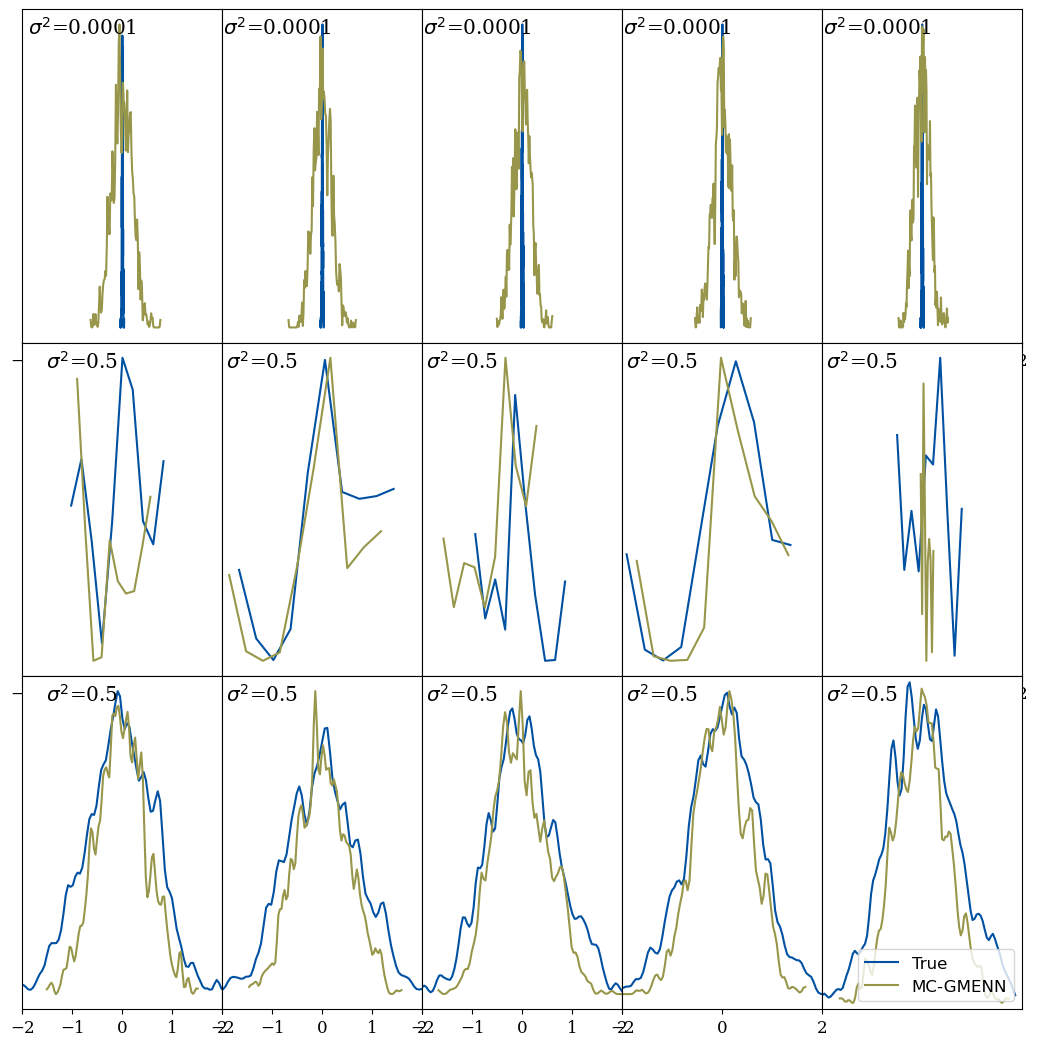

In [24]:
### For Appendix
re_diffs = {}
random_effects = {}

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(10, 10))

scenario_key = "base"
num = 0
L,C = np.array(scenarios[scenario_key]["sig2bs"]).shape

random_effects = results[scenario_key][num]["other_info"]["GMENN"]["random_effects"]
learned_stds = results[scenario_key][num]["other_info"]["GMENN"]["_stddev_z"]


for l in range(L):
    
#     if scenario_num in [0,1,2]:
#         axes[q_map[q],std_map[std]].set_ylabel(f"$Q$={scenario_key.split(',')[1]}")
#     if scenario_num in [2,5,8]:
#         axes[q_map[q],std_map[std]].set_xlabel(f"$\sigma^2$={scenario_key.split(',')[0]}")

    for c in range(C):
        re = datasets[scenario_key][num][-1][l][:,c]
        edges_menn = np.linspace(re.min() - 1e-10, re.max() + 1e-10, np.min([100, len(np.unique(re))]))
        kde_menn = FFTKDE(kernel='gaussian', bw="ISJ",).fit(re)
        probabilities_menn = kde_menn.evaluate(edges_menn)
        axes[l,c].plot(edges_menn, probabilities_menn/probabilities_menn.std(),color=colors_[0])

        re = random_effects[l][:,c].numpy().ravel()
        edges_menn = np.linspace(re.min() - 1e-10, re.max() + 1e-10, np.min([100, len(np.unique(re))]))
        kde_menn = FFTKDE(kernel='gaussian', bw="ISJ").fit(re)
        probabilities_menn = kde_menn.evaluate(edges_menn)
        axes[l,c].plot(edges_menn, probabilities_menn/probabilities_menn.std(),color=colors_[1])
        axes[l,c].set_xlim([-2, 2])
#         axes[l,c].set_ylim([-2, 2])
        axes[l,c].set(yticks=[])
        if c==0:
            axes[l,c].set_title(f"$\sigma^2$={scenarios[scenario_key]['sig2bs'][l][c]}", y=0.9,x=0.3)
        elif l==0:
            axes[l,c].set_title(f"$\sigma^2$={scenarios[scenario_key]['sig2bs'][l][c]}", y=0.9,x=0.275)
        else:
            axes[l,c].set_title(f"$\sigma^2$={scenarios[scenario_key]['sig2bs'][l][c]}", y=0.9,x=0.2)

            
            
plt.style.use('default')
# # plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['axes.linewidth'] = lwidth
plt.rcParams['legend.handlelength'] = lhandle

# plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0.02,0.02)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

plt.legend([f"True","MC-GMENN", "LMMNN" ,"ARMED"],loc="lower right")

plt.savefig(f'learned_re_comparison_{scenario_key}.svg', format='svg',bbox_inches='tight', pad_inches = 0)

plt.show()

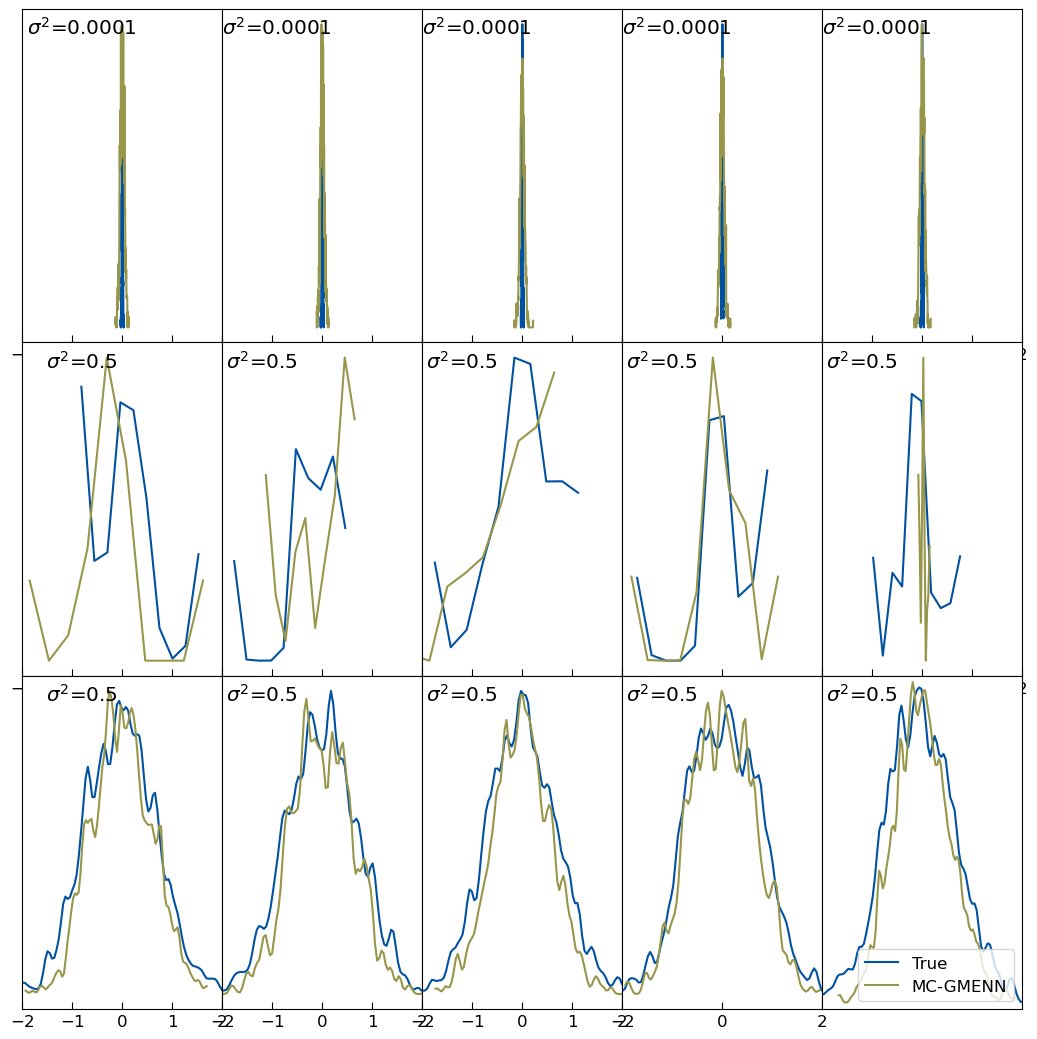

In [25]:
### For Appendix
re_diffs = {}
random_effects = {}

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(10, 10))

scenario_key = "1Msamples"
num = 0
L,C = np.array(scenarios[scenario_key]["sig2bs"]).shape

random_effects = results[scenario_key][num]["other_info"]["GMENN"]["random_effects"]
learned_stds = results[scenario_key][num]["other_info"]["GMENN"]["_stddev_z"]


for l in range(L):
    
#     if scenario_num in [0,1,2]:
#         axes[q_map[q],std_map[std]].set_ylabel(f"$Q$={scenario_key.split(',')[1]}")
#     if scenario_num in [2,5,8]:
#         axes[q_map[q],std_map[std]].set_xlabel(f"$\sigma^2$={scenario_key.split(',')[0]}")

    for c in range(C):
        re = datasets[scenario_key][num][-1][l][:,c]
        edges_menn = np.linspace(re.min() - 1e-10, re.max() + 1e-10, np.min([100, len(np.unique(re))]))
        kde_menn = FFTKDE(kernel='gaussian', bw="ISJ",).fit(re)
        probabilities_menn = kde_menn.evaluate(edges_menn)
        axes[l,c].plot(edges_menn, probabilities_menn/probabilities_menn.std(),color=colors_[0])

        re = random_effects[l][:,c].numpy().ravel()
        edges_menn = np.linspace(re.min() - 1e-10, re.max() + 1e-10, np.min([100, len(np.unique(re))]))
        kde_menn = FFTKDE(kernel='gaussian', bw="ISJ").fit(re)
        probabilities_menn = kde_menn.evaluate(edges_menn)
        axes[l,c].plot(edges_menn, probabilities_menn/probabilities_menn.std(),color=colors_[1])
        axes[l,c].set_xlim([-2, 2])
#         axes[l,c].set_ylim([-2, 2])
        axes[l,c].set(yticks=[])
        if c==0:
            axes[l,c].set_title(f"$\sigma^2$={scenarios[scenario_key]['sig2bs'][l][c]}", y=0.9,x=0.3)
        elif l==0:
            axes[l,c].set_title(f"$\sigma^2$={scenarios[scenario_key]['sig2bs'][l][c]}", y=0.9,x=0.275)
        else:
            axes[l,c].set_title(f"$\sigma^2$={scenarios[scenario_key]['sig2bs'][l][c]}", y=0.9,x=0.2)

            
            
plt.style.use('default')
# # plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['axes.linewidth'] = lwidth
plt.rcParams['legend.handlelength'] = lhandle

# plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0.02,0.02)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

plt.legend([f"True","MC-GMENN", "LMMNN" ,"ARMED"],loc="lower right")

plt.savefig(f'learned_re_comparison_{scenario_key}.svg', format='svg',bbox_inches='tight', pad_inches = 0)

plt.show()

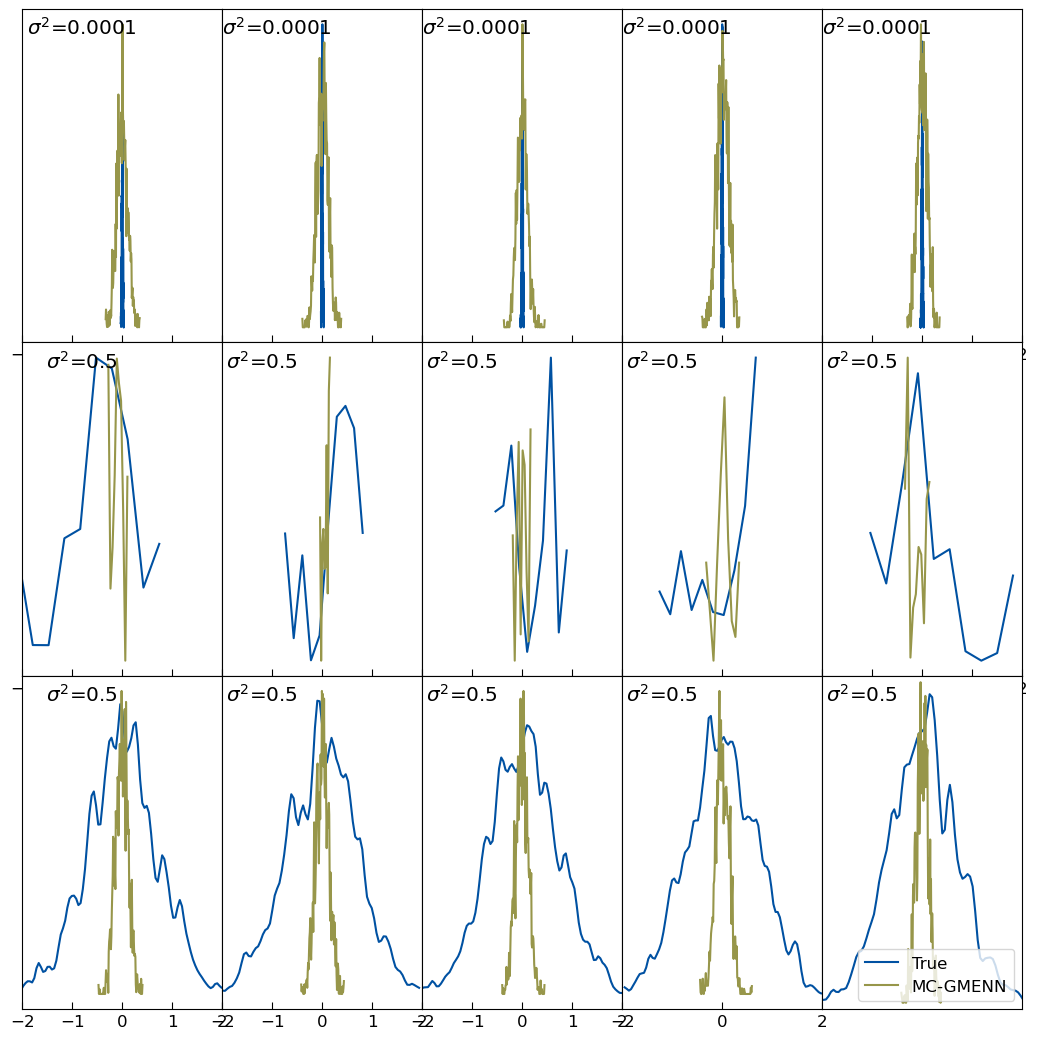

In [26]:
### For Appendix
re_diffs = {}
random_effects = {}

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(10, 10))

scenario_key = "1000features"
num = 0
L,C = np.array(scenarios[scenario_key]["sig2bs"]).shape

random_effects = results[scenario_key][num]["other_info"]["GMENN"]["random_effects"]
learned_stds = results[scenario_key][num]["other_info"]["GMENN"]["_stddev_z"]


for l in range(L):
    
#     if scenario_num in [0,1,2]:
#         axes[q_map[q],std_map[std]].set_ylabel(f"$Q$={scenario_key.split(',')[1]}")
#     if scenario_num in [2,5,8]:
#         axes[q_map[q],std_map[std]].set_xlabel(f"$\sigma^2$={scenario_key.split(',')[0]}")

    for c in range(C):
        re = datasets[scenario_key][num][-1][l][:,c]
        edges_menn = np.linspace(re.min() - 1e-10, re.max() + 1e-10, np.min([100, len(np.unique(re))]))
        kde_menn = FFTKDE(kernel='gaussian', bw="ISJ",).fit(re)
        probabilities_menn = kde_menn.evaluate(edges_menn)
        axes[l,c].plot(edges_menn, probabilities_menn/probabilities_menn.std(),color=colors_[0])

        re = random_effects[l][:,c].numpy().ravel()
        edges_menn = np.linspace(re.min() - 1e-10, re.max() + 1e-10, np.min([100, len(np.unique(re))]))
        kde_menn = FFTKDE(kernel='gaussian', bw="ISJ").fit(re)
        probabilities_menn = kde_menn.evaluate(edges_menn)
        axes[l,c].plot(edges_menn, probabilities_menn/probabilities_menn.std(),color=colors_[1])
        axes[l,c].set_xlim([-2, 2])
#         axes[l,c].set_ylim([-2, 2])
        axes[l,c].set(yticks=[])
        if c==0:
            axes[l,c].set_title(f"$\sigma^2$={scenarios[scenario_key]['sig2bs'][l][c]}", y=0.9,x=0.3)
        elif l==0:
            axes[l,c].set_title(f"$\sigma^2$={scenarios[scenario_key]['sig2bs'][l][c]}", y=0.9,x=0.275)
        else:
            axes[l,c].set_title(f"$\sigma^2$={scenarios[scenario_key]['sig2bs'][l][c]}", y=0.9,x=0.2)

            
            
plt.style.use('default')
# # plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['axes.linewidth'] = lwidth
plt.rcParams['legend.handlelength'] = lhandle

# plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0.02,0.02)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

plt.legend([f"True","MC-GMENN", "LMMNN" ,"ARMED"],loc="lower right")

plt.savefig(f'learned_re_comparison_{scenario_key}.svg', format='svg',bbox_inches='tight', pad_inches = 0)

plt.show()

In [27]:
scenarios.keys()

dict_keys(['base', '1Msamples', '1000features', '100classes', 'high_cardinality', 'dominatRE', 'irrelevantRE', 'class_variations', '10RE'])

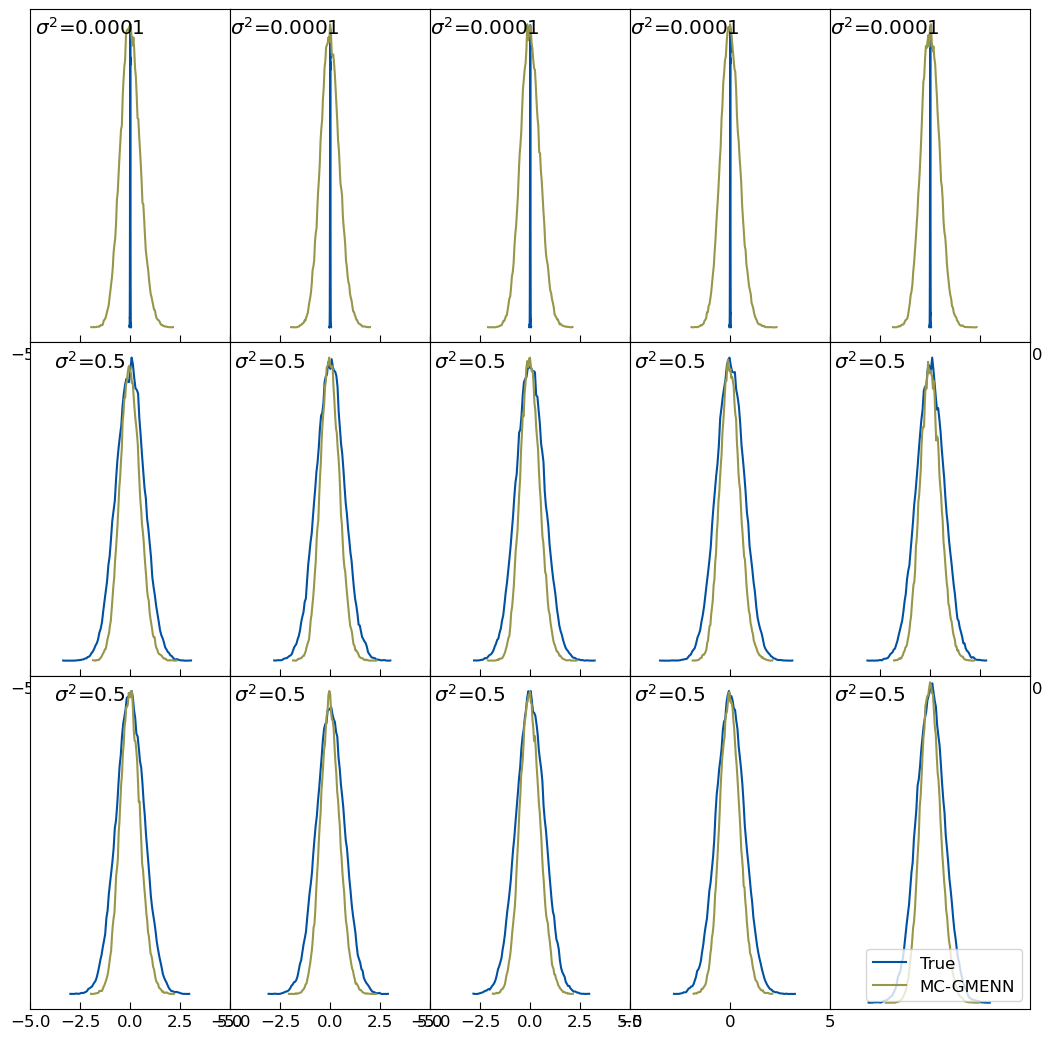

In [28]:
### For Appendix
re_diffs = {}
random_effects = {}

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(10, 10))

scenario_key = "high_cardinality"
num = 0
L,C = np.array(scenarios[scenario_key]["sig2bs"]).shape

random_effects = results[scenario_key][num]["other_info"]["GMENN"]["random_effects"]
learned_stds = results[scenario_key][num]["other_info"]["GMENN"]["_stddev_z"]


for l in range(L):
    
#     if scenario_num in [0,1,2]:
#         axes[q_map[q],std_map[std]].set_ylabel(f"$Q$={scenario_key.split(',')[1]}")
#     if scenario_num in [2,5,8]:
#         axes[q_map[q],std_map[std]].set_xlabel(f"$\sigma^2$={scenario_key.split(',')[0]}")

    for c in range(C):
        re = datasets[scenario_key][num][-1][l][:,c]
        edges_menn = np.linspace(re.min() - 1e-10, re.max() + 1e-10, np.min([100, len(np.unique(re))]))
        kde_menn = FFTKDE(kernel='gaussian', bw="ISJ",).fit(re)
        probabilities_menn = kde_menn.evaluate(edges_menn)
        axes[l,c].plot(edges_menn, probabilities_menn/probabilities_menn.std(),color=colors_[0])

        re = random_effects[l][:,c].numpy().ravel()
        edges_menn = np.linspace(re.min() - 1e-10, re.max() + 1e-10, np.min([100, len(np.unique(re))]))
        kde_menn = FFTKDE(kernel='gaussian', bw="ISJ").fit(re)
        probabilities_menn = kde_menn.evaluate(edges_menn)
        axes[l,c].plot(edges_menn, probabilities_menn/probabilities_menn.std(),color=colors_[1])
        
        axes[l,c].set_xlim([-5, 5])
#         axes[l,c].set_ylim([-2, 2])
        axes[l,c].set(yticks=[])
        if c==0:
            axes[l,c].set_title(f"$\sigma^2$={scenarios[scenario_key]['sig2bs'][l][c]}", y=0.9,x=0.3)
        elif l==0:
            axes[l,c].set_title(f"$\sigma^2$={scenarios[scenario_key]['sig2bs'][l][c]}", y=0.9,x=0.275)
        else:
            axes[l,c].set_title(f"$\sigma^2$={scenarios[scenario_key]['sig2bs'][l][c]}", y=0.9,x=0.2)

            
            
plt.style.use('default')
# # plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['axes.linewidth'] = lwidth
plt.rcParams['legend.handlelength'] = lhandle

# plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0.02,0.02)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

plt.legend([f"True","MC-GMENN", "LMMNN" ,"ARMED"],loc="lower right")

plt.savefig(f'learned_re_comparison_{scenario_key}.svg', format='svg',bbox_inches='tight', pad_inches = 0)

plt.show()

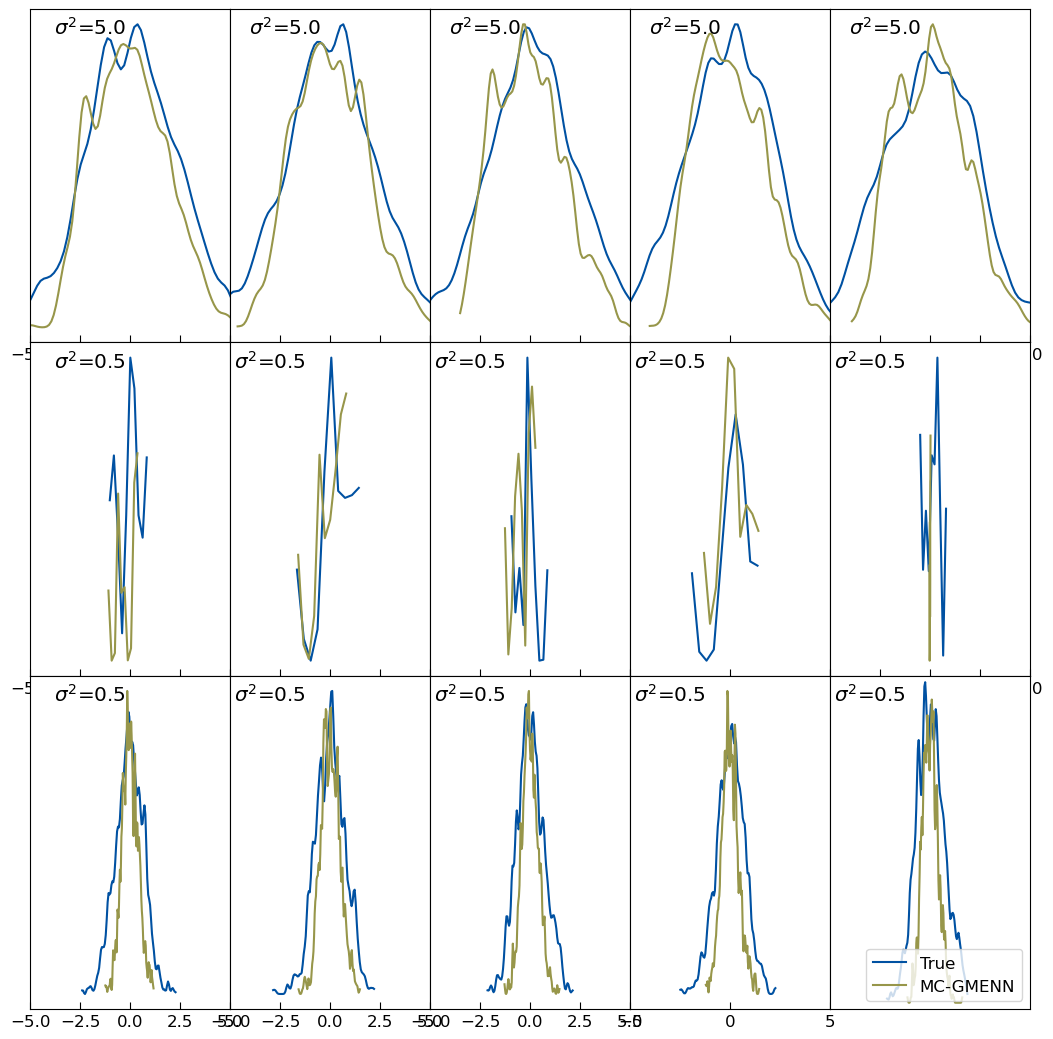

In [29]:
### For Appendix
re_diffs = {}
random_effects = {}

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(10, 10))

scenario_key = "dominatRE"
num = 0
L,C = np.array(scenarios[scenario_key]["sig2bs"]).shape

random_effects = results[scenario_key][num]["other_info"]["GMENN"]["random_effects"]
learned_stds = results[scenario_key][num]["other_info"]["GMENN"]["_stddev_z"]


for l in range(L):
    
#     if scenario_num in [0,1,2]:
#         axes[q_map[q],std_map[std]].set_ylabel(f"$Q$={scenario_key.split(',')[1]}")
#     if scenario_num in [2,5,8]:
#         axes[q_map[q],std_map[std]].set_xlabel(f"$\sigma^2$={scenario_key.split(',')[0]}")

    for c in range(C):
        re = datasets[scenario_key][num][-1][l][:,c]
        edges_menn = np.linspace(re.min() - 1e-10, re.max() + 1e-10, np.min([100, len(np.unique(re))]))
        kde_menn = FFTKDE(kernel='gaussian', bw="ISJ",).fit(re)
        probabilities_menn = kde_menn.evaluate(edges_menn)
        axes[l,c].plot(edges_menn, probabilities_menn/probabilities_menn.std(),color=colors_[0])

        re = random_effects[l][:,c].numpy().ravel()
        edges_menn = np.linspace(re.min() - 1e-10, re.max() + 1e-10, np.min([100, len(np.unique(re))]))
        kde_menn = FFTKDE(kernel='gaussian', bw="ISJ").fit(re)
        probabilities_menn = kde_menn.evaluate(edges_menn)
        axes[l,c].plot(edges_menn, probabilities_menn/probabilities_menn.std(),color=colors_[1])
        axes[l,c].set_xlim([-5, 5])
#         axes[l,c].set_ylim([-2, 2])
        axes[l,c].set(yticks=[])
        if c==0:
            axes[l,c].set_title(f"$\sigma^2$={scenarios[scenario_key]['sig2bs'][l][c]}", y=0.9,x=0.3)
        elif l==0:
            axes[l,c].set_title(f"$\sigma^2$={scenarios[scenario_key]['sig2bs'][l][c]}", y=0.9,x=0.275)
        else:
            axes[l,c].set_title(f"$\sigma^2$={scenarios[scenario_key]['sig2bs'][l][c]}", y=0.9,x=0.2)

            
            
plt.style.use('default')
# # plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['axes.linewidth'] = lwidth
plt.rcParams['legend.handlelength'] = lhandle

# plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0.02,0.02)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

plt.legend([f"True","MC-GMENN", "LMMNN" ,"ARMED"],loc="lower right")

plt.savefig(f'learned_re_comparison_{scenario_key}.svg', format='svg',bbox_inches='tight', pad_inches = 0)

plt.show()

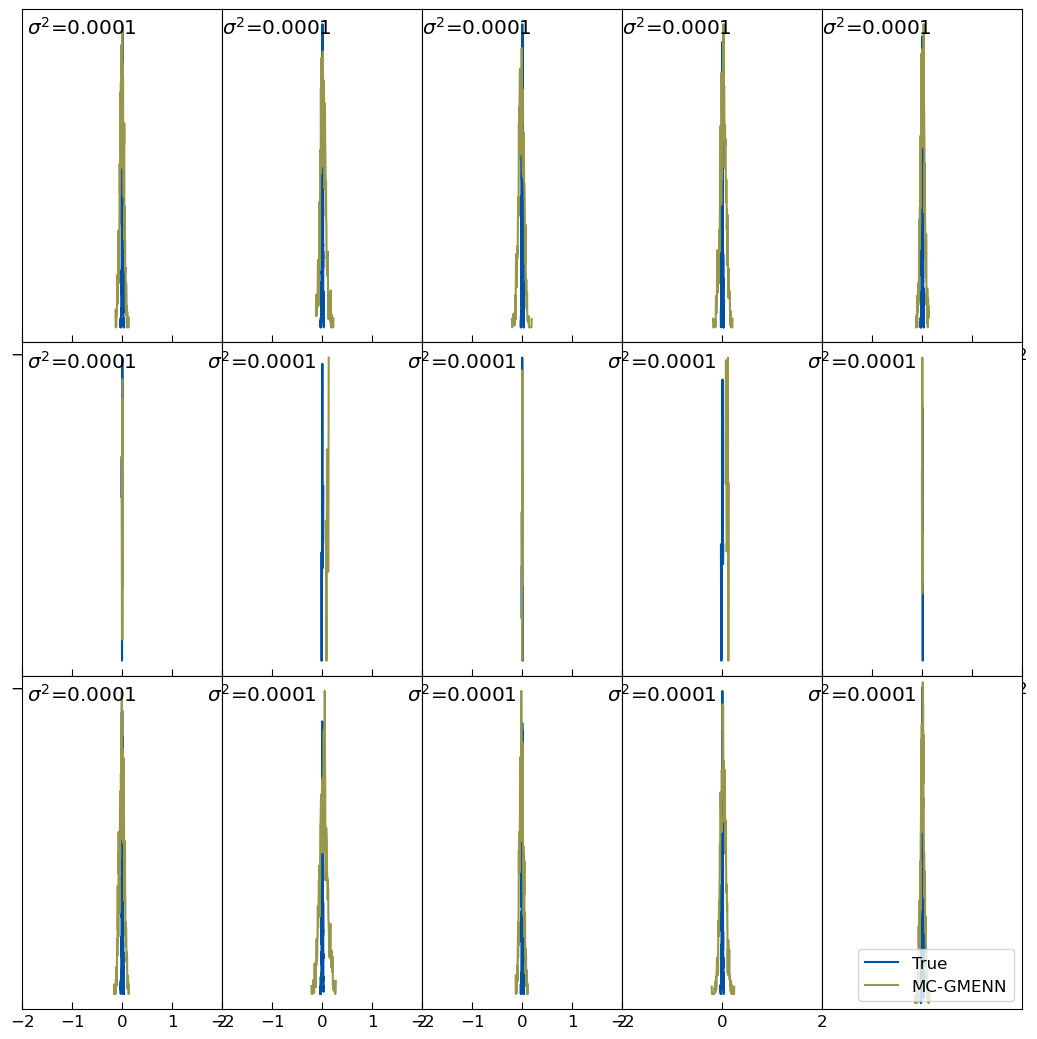

In [30]:
### For Appendix
re_diffs = {}
random_effects = {}

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(10, 10))

scenario_key = "irrelevantRE"
num = 0
L,C = np.array(scenarios[scenario_key]["sig2bs"]).shape

random_effects = results[scenario_key][num]["other_info"]["GMENN"]["random_effects"]
learned_stds = results[scenario_key][num]["other_info"]["GMENN"]["_stddev_z"]


for l in range(L):
    
#     if scenario_num in [0,1,2]:
#         axes[q_map[q],std_map[std]].set_ylabel(f"$Q$={scenario_key.split(',')[1]}")
#     if scenario_num in [2,5,8]:
#         axes[q_map[q],std_map[std]].set_xlabel(f"$\sigma^2$={scenario_key.split(',')[0]}")

    for c in range(C):
        re = datasets[scenario_key][num][-1][l][:,c]
        edges_menn = np.linspace(re.min() - 1e-10, re.max() + 1e-10, np.min([100, len(np.unique(re))]))
        kde_menn = FFTKDE(kernel='gaussian', bw="ISJ",).fit(re)
        probabilities_menn = kde_menn.evaluate(edges_menn)
        axes[l,c].plot(edges_menn, probabilities_menn/probabilities_menn.std(),color=colors_[0])

        re = random_effects[l][:,c].numpy().ravel()
        edges_menn = np.linspace(re.min() - 1e-10, re.max() + 1e-10, np.min([100, len(np.unique(re))]))
        kde_menn = FFTKDE(kernel='gaussian', bw="ISJ").fit(re)
        probabilities_menn = kde_menn.evaluate(edges_menn)
        axes[l,c].plot(edges_menn, probabilities_menn/probabilities_menn.std(),color=colors_[1])
        axes[l,c].set_xlim([-2, 2])
#         axes[l,c].set_ylim([-2, 2])
        axes[l,c].set(yticks=[])
        if c==0:
            axes[l,c].set_title(f"$\sigma^2$={scenarios[scenario_key]['sig2bs'][l][c]}", y=0.9,x=0.3)
        elif l==0:
            axes[l,c].set_title(f"$\sigma^2$={scenarios[scenario_key]['sig2bs'][l][c]}", y=0.9,x=0.275)
        else:
            axes[l,c].set_title(f"$\sigma^2$={scenarios[scenario_key]['sig2bs'][l][c]}", y=0.9,x=0.2)

            
            
plt.style.use('default')
# # plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['axes.linewidth'] = lwidth
plt.rcParams['legend.handlelength'] = lhandle

# plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0.02,0.02)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

plt.legend([f"True","MC-GMENN", "LMMNN" ,"ARMED"],loc="lower right")

plt.savefig(f'learned_re_comparison_{scenario_key}.svg', format='svg',bbox_inches='tight', pad_inches = 0)

plt.show()

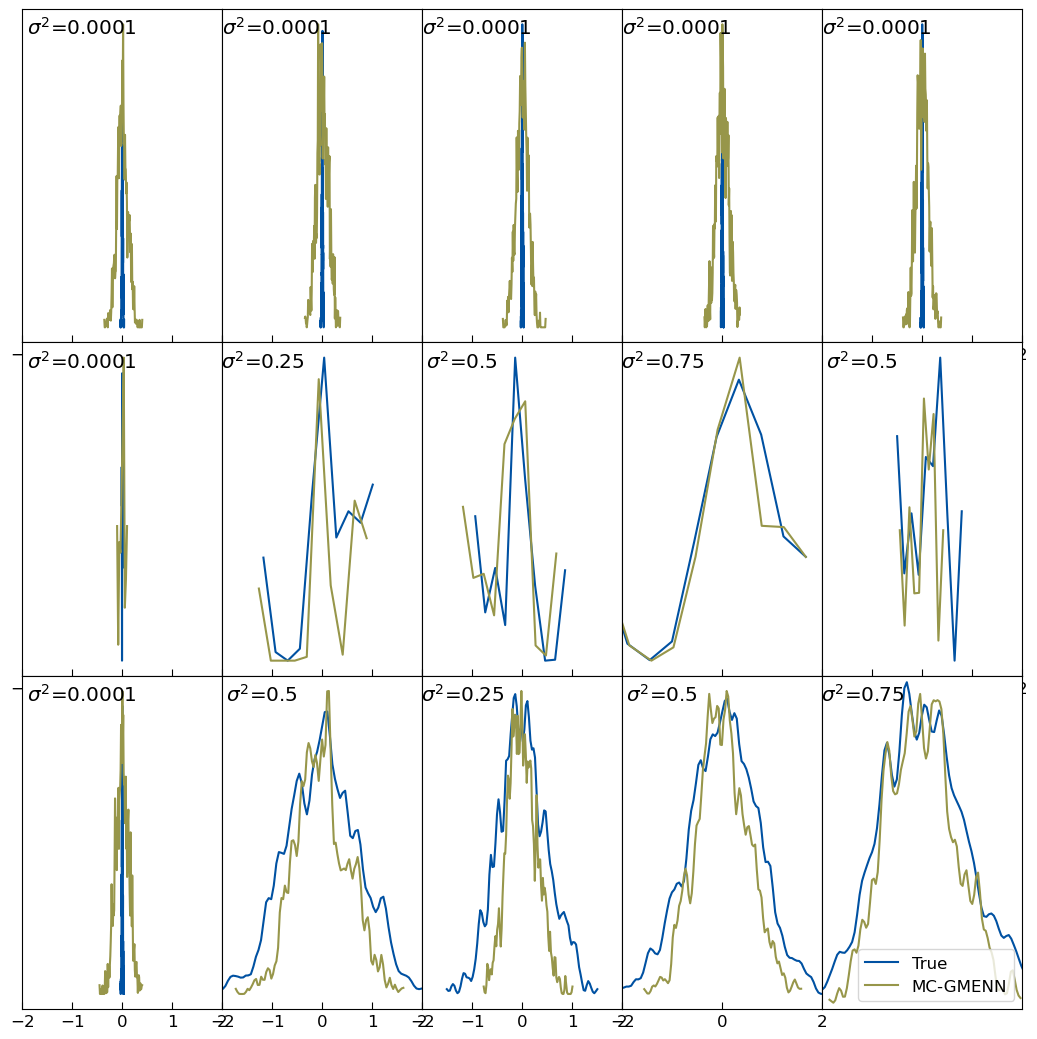

In [31]:
### For Appendix
re_diffs = {}
random_effects = {}

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(10, 10))

scenario_key = "class_variations"
num = 0
L,C = np.array(scenarios[scenario_key]["sig2bs"]).shape

random_effects = results[scenario_key][num]["other_info"]["GMENN"]["random_effects"]
learned_stds = results[scenario_key][num]["other_info"]["GMENN"]["_stddev_z"]


for l in range(L):
    
#     if scenario_num in [0,1,2]:
#         axes[q_map[q],std_map[std]].set_ylabel(f"$Q$={scenario_key.split(',')[1]}")
#     if scenario_num in [2,5,8]:
#         axes[q_map[q],std_map[std]].set_xlabel(f"$\sigma^2$={scenario_key.split(',')[0]}")

    for c in range(C):
        re = datasets[scenario_key][num][-1][l][:,c]
        edges_menn = np.linspace(re.min() - 1e-10, re.max() + 1e-10, np.min([100, len(np.unique(re))]))
        kde_menn = FFTKDE(kernel='gaussian', bw="ISJ",).fit(re)
        probabilities_menn = kde_menn.evaluate(edges_menn)
        axes[l,c].plot(edges_menn, probabilities_menn/probabilities_menn.std(),color=colors_[0])

        re = random_effects[l][:,c].numpy().ravel()
        edges_menn = np.linspace(re.min() - 1e-10, re.max() + 1e-10, np.min([100, len(np.unique(re))]))
        kde_menn = FFTKDE(kernel='gaussian', bw="ISJ").fit(re)
        probabilities_menn = kde_menn.evaluate(edges_menn)
        axes[l,c].plot(edges_menn, probabilities_menn/probabilities_menn.std(),color=colors_[1])
        axes[l,c].set_xlim([-2, 2])
#         axes[l,c].set_ylim([-2, 2])
        axes[l,c].set(yticks=[])
        if c==0:
            axes[l,c].set_title(f"$\sigma^2$={scenarios[scenario_key]['sig2bs'][l][c]}", y=0.9,x=0.3)
        elif l==0:
            axes[l,c].set_title(f"$\sigma^2$={scenarios[scenario_key]['sig2bs'][l][c]}", y=0.9,x=0.275)
        else:
            axes[l,c].set_title(f"$\sigma^2$={scenarios[scenario_key]['sig2bs'][l][c]}", y=0.9,x=0.2)

            
            
plt.style.use('default')
# # plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['axes.linewidth'] = lwidth
plt.rcParams['legend.handlelength'] = lhandle

# plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0.02,0.02)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

plt.legend([f"True","MC-GMENN", "LMMNN" ,"ARMED"],loc="lower right")

plt.savefig(f'learned_re_comparison_{scenario_key}.svg', format='svg',bbox_inches='tight', pad_inches = 0)

plt.show()

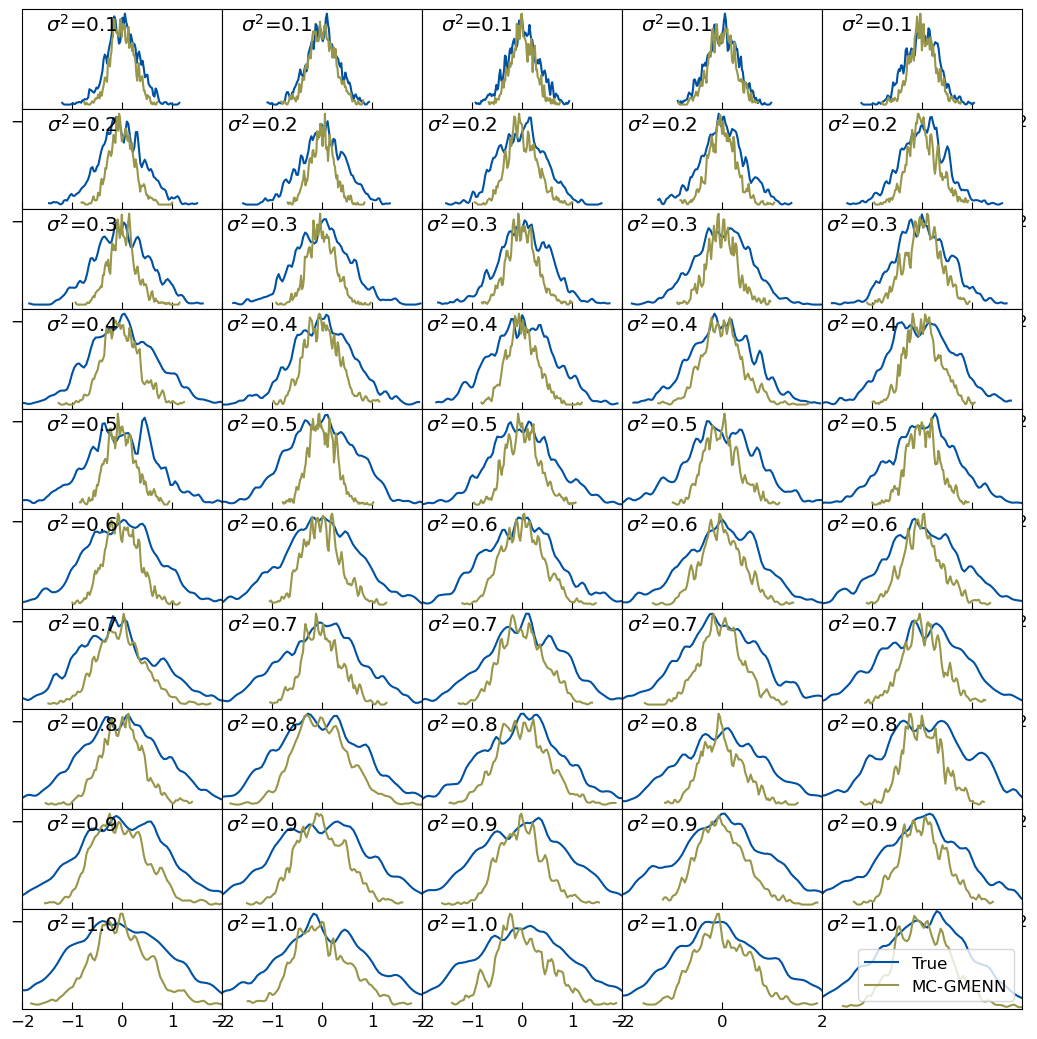

In [32]:
### For Appendix
re_diffs = {}
random_effects = {}

scenario_key = "10RE"
num = 0
L,C = np.array(scenarios[scenario_key]["sig2bs"]).shape

fig, axes = plt.subplots(nrows=L, ncols=C, figsize=(10, 10))

random_effects = results[scenario_key][num]["other_info"]["GMENN"]["random_effects"]
learned_stds = results[scenario_key][num]["other_info"]["GMENN"]["_stddev_z"]


for l in range(L):
    
#     if scenario_num in [0,1,2]:
#         axes[q_map[q],std_map[std]].set_ylabel(f"$Q$={scenario_key.split(',')[1]}")
#     if scenario_num in [2,5,8]:
#         axes[q_map[q],std_map[std]].set_xlabel(f"$\sigma^2$={scenario_key.split(',')[0]}")

    for c in range(C):
        re = datasets[scenario_key][num][-1][l][:,c]
        edges_menn = np.linspace(re.min() - 1e-10, re.max() + 1e-10, np.min([100, len(np.unique(re))]))
        kde_menn = FFTKDE(kernel='gaussian', bw="ISJ",).fit(re)
        probabilities_menn = kde_menn.evaluate(edges_menn)
        axes[l,c].plot(edges_menn, probabilities_menn/probabilities_menn.std(),color=colors_[0])

        re = random_effects[l][:,c].numpy().ravel()
        edges_menn = np.linspace(re.min() - 1e-10, re.max() + 1e-10, np.min([100, len(np.unique(re))]))
        kde_menn = FFTKDE(kernel='gaussian', bw="ISJ").fit(re)
        probabilities_menn = kde_menn.evaluate(edges_menn)
        axes[l,c].plot(edges_menn, probabilities_menn/probabilities_menn.std(),color=colors_[1])
        axes[l,c].set_xlim([-2, 2])
#         axes[l,c].set_ylim([-2, 2])
        axes[l,c].set(yticks=[])
        if c==0:
            axes[l,c].set_title(f"$\sigma^2$={scenarios[scenario_key]['sig2bs'][l][c]}", y=0.7,x=0.3)
        elif l==0:
            axes[l,c].set_title(f"$\sigma^2$={scenarios[scenario_key]['sig2bs'][l][c]}", y=0.7,x=0.275)
        else:
            axes[l,c].set_title(f"$\sigma^2$={scenarios[scenario_key]['sig2bs'][l][c]}", y=0.7,x=0.2)

            
            
plt.style.use('default')
# # plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['axes.linewidth'] = lwidth
plt.rcParams['legend.handlelength'] = lhandle

# plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0.02,0.02)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

plt.legend([f"True","MC-GMENN", "LMMNN" ,"ARMED"],loc="lower right")

plt.savefig(f'learned_re_comparison_{scenario_key}.svg', format='svg',bbox_inches='tight', pad_inches = 0)

plt.show()

### Learned STD

In [33]:
re_stds_mean = {}
re_stds_mean_random = {}
scenario_abs_diffs = {}
scenario_abs_diffs_random = {}
for scenario_key in scenarios:
    re_stds_mean[scenario_key] = []
    re_stds_mean_random[scenario_key] = []

    scenario_abs_diffs[scenario_key] = {}
    scenario_abs_diffs_random[scenario_key] = {}
    for num in range(iterations):
        random_effects = results[scenario_key][num]["other_info"]["GMENN"]["random_effects"]
        learned_stds = results[scenario_key][num]["other_info"]["GMENN"]["_stddev_z"]**2

        scenario_abs_diffs[scenario_key][num] = np.abs(results[scenario_key][num]["other_info"]["GMENN"]["_stddev_z"]**2-np.array(scenarios[scenario_key]["sig2bs"])).mean()
        scenario_abs_diffs_random[scenario_key][num] = np.abs(results[scenario_key][num]["other_info"]["GMENN"]["_stddev_z"]**2-1).mean()
        
        re_stds_mean_random[scenario_key].append((np.abs(scenarios[scenario_key]["sig2bs"]-np.mean(scenarios[scenario_key]["sig2bs"]))/scenarios[scenario_key]["sig2bs"]).mean())
        re_stds_mean[scenario_key].append((np.abs(scenarios[scenario_key]["sig2bs"]-learned_stds)/scenarios[scenario_key]["sig2bs"]).mean())
        
        L = len(datasets[scenario_key][num][-1])
        C = datasets[scenario_key][num][-1][0].shape[1]



In [34]:
pd.Series({scenario_key: np.mean(scenarios[scenario_key]["sig2bs"]).round(2) for scenario_key in scenarios})

base                0.33
1Msamples           0.33
1000features        0.33
100classes          0.33
high_cardinality    0.33
dominatRE           2.00
irrelevantRE        0.00
class_variations    0.27
10RE                0.55
dtype: float64

In [35]:
pd.DataFrame(scenario_abs_diffs_random).mean().round(2)

base                0.70
1Msamples           0.68
1000features        0.96
100classes          0.64
high_cardinality    0.12
dominatRE           1.57
irrelevantRE        0.99
class_variations    0.77
10RE                0.49
dtype: float32

In [36]:
pd.DataFrame(scenario_abs_diffs_random).mean().round(2)-pd.DataFrame(scenario_abs_diffs).mean().round(2)

base                0.59
1Msamples           0.57
1000features        0.64
100classes          0.46
high_cardinality   -0.43
dominatRE           1.26
irrelevantRE        0.98
class_variations    0.68
10RE                0.38
dtype: float64

In [37]:
pd.DataFrame(scenario_abs_diffs).mean().round(2)

base                0.11
1Msamples           0.11
1000features        0.32
100classes          0.18
high_cardinality    0.55
dominatRE           0.31
irrelevantRE        0.01
class_variations    0.09
10RE                0.11
dtype: float64

In [38]:
print(pd.concat([(mean_df.loc["GMENN"]/mean_df.loc["Ignore"]).round(2),pd.DataFrame(scenario_abs_diffs).mean().round(2)],axis=1).to_latex(index=True))

\begin{tabular}{lrr}
\toprule
{} &     0 &     1 \\
\midrule
base             &  1.13 &  0.11 \\
1Msamples        &  2.32 &  0.11 \\
1000features     &  1.68 &  0.32 \\
100classes       &  4.87 &  0.18 \\
high\_cardinality &  2.46 &  0.55 \\
dominatRE        &  2.33 &  0.31 \\
irrelevantRE     &  2.67 &  0.01 \\
class\_variations &  1.73 &  0.09 \\
10RE             &  2.36 &  0.11 \\
\bottomrule
\end{tabular}



<ipython-input-38-d32d850e95a1>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.concat([(mean_df.loc["GMENN"]/mean_df.loc["Ignore"]).round(2),pd.DataFrame(scenario_abs_diffs).mean().round(2)],axis=1).to_latex(index=True))


In [41]:
re_stds_mean = {}
re_stds_mean_random = {}
scenario_abs_diffs = {}
scenario_abs_diffs_random = {}

stds_all = {}

for scenario_key in scenarios:
    re_stds_mean[scenario_key] = []
    re_stds_mean_random[scenario_key] = []
    stds_all[scenario_key] = {}
    
    scenario_abs_diffs[scenario_key] = {}
    scenario_abs_diffs_random[scenario_key] = {}
    for num in range(iterations):
        random_effects = results[scenario_key][num]["other_info"]["GMENN"]["random_effects"]
        learned_stds = results[scenario_key][num]["other_info"]["GMENN"]["_stddev_z"]**2

        stds_all[scenario_key][num] = learned_stds
        
        scenario_abs_diffs[scenario_key][num] = np.abs(results[scenario_key][num]["other_info"]["GMENN"]["_stddev_z"]**2-np.array(scenarios[scenario_key]["sig2bs"])).mean()
        scenario_abs_diffs_random[scenario_key][num] = np.abs(results[scenario_key][num]["other_info"]["GMENN"]["_stddev_z"]**2-1).mean()
        
        re_stds_mean_random[scenario_key].append((np.abs(scenarios[scenario_key]["sig2bs"]-np.mean(scenarios[scenario_key]["sig2bs"]))/scenarios[scenario_key]["sig2bs"]).mean())
        re_stds_mean[scenario_key].append((np.abs(scenarios[scenario_key]["sig2bs"]-learned_stds)/scenarios[scenario_key]["sig2bs"]).mean())
        


#### All stds for Latex

In [42]:
sig_df_dict = {}
for scenario_key in scenarios:
    df_std_mean = pd.DataFrame(np.array(list(stds_all[scenario_key].values())).mean(axis=0).round(2)).astype(str).transpose()
    df_std_std = pd.DataFrame(np.array(list(stds_all[scenario_key].values())).mean(axis=0).round(3)).astype(str).transpose()

    sig_df_dict[scenario_key] = df_std_mean+" (" + df_std_std + ")"


In [43]:
scenarios_use = ['base',
                 '1Msamples',
                 '1000features',
                 '100classes',
                 'high_cardinality',
                 'dominatRE',
                 'irrelevantRE',
                 'class_variations',
#                  '10RE'
                ]

In [44]:
def get_latex_df(sig_df_dict,scenario_key):
#     scenario_key = list(scenarios.keys())[0]
    
    sig_df_dict[scenario_key].columns = ["$\hat{\sigma}_{" + str(i+1) +"c}$" for i in range(sig_df_dict[scenario_key].shape[1])]
    sig_df_dict[scenario_key].index = [f"$c={i+1}$" for i in range(sig_df_dict[scenario_key].shape[0])]

    true_var_df = pd.DataFrame(scenarios[scenario_key]["sig2bs"],columns=sig_df_dict[scenario_key].index).transpose().round(2)
    true_var_df.columns =  ["$\sigma_{" + str(i+1) +"c}$" for i in range(sig_df_dict[scenario_key].shape[1])]

    latex_var_df = pd.concat([true_var_df,sig_df_dict[scenario_key]],axis=1)
    return latex_var_df.iloc[:5,:]

In [45]:
scenario_stds_df = pd.concat({scenario_key: get_latex_df(sig_df_dict,scenario_key) for scenario_key in scenarios_use})
scenario_stds_df

$\sigma_{1c}$  $\sigma_{2c}$  $\sigma_{3c}$  \
base             $c=1$            0.0           0.50           0.50   
                 $c=2$            0.0           0.50           0.50   
                 $c=3$            0.0           0.50           0.50   
                 $c=4$            0.0           0.50           0.50   
                 $c=5$            0.0           0.50           0.50   
1Msamples        $c=1$            0.0           0.50           0.50   
                 $c=2$            0.0           0.50           0.50   
                 $c=3$            0.0           0.50           0.50   
                 $c=4$            0.0           0.50           0.50   
                 $c=5$            0.0           0.50           0.50   
1000features     $c=1$            0.0           0.50           0.50   
                 $c=2$            0.0           0.50           0.50   
                 $c=3$            0.0           0.50           0.50   
                 $c=4$            0.0           0.50           0.50   
                 $c=5$            0.0           0.50           0.50   
100classes       $c=1$            0.0           0.50           0.50   
                 $c=2$            0.0           0.50           0.50   
                 $c=3$            0.0           0.50           0.50   
                 $c=4$            0.0           0.50           0.50   
                 $c=5$            0.0           0.50           0.50   
high_cardinality $c=1$            0.0           0.50           0.50   
                 $c=2$            0.0           0.50           0.50   
                 $c=3$            0.0           0.50           0.50   
                 $c=4$            0.0           0.50           0.50   
                 $c=5$            0.0           0.50           0.50   
dominatRE        $c=1$            5.0           0.50           0.50   
                 $c=2$            5.0           0.50           0.50   
                 $c=3$            5.0           0.50           0.50   
                 $c=4$            5.0           0.50           0.50   
                 $c=5$            5.0           0.50           0.50   
irrelevantRE     $c=1$            0.0           0.00           0.00   
                 $c=2$            0.0           0.00           0.00   
                 $c=3$            0.0           0.00           0.00   
                 $c=4$            0.0           0.00           0.00   
                 $c=5$            0.0           0.00           0.00   
class_variations $c=1$            0.0           0.00           0.00   
                 $c=2$            0.0           0.25           0.50   
                 $c=3$            0.0           0.50           0.25   
                 $c=4$            0.0           0.75           0.50   
                 $c=5$            0.0           0.50           0.75   

                       $\hat{\sigma}_{1c}$ $\hat{\sigma}_{2c}$  \
base             $c=1$        0.06 (0.062)         0.5 (0.504)   
                 $c=2$        0.06 (0.062)        0.44 (0.436)   
                 $c=3$        0.06 (0.062)        0.41 (0.409)   
                 $c=4$        0.06 (0.063)        0.35 (0.348)   
                 $c=5$         0.05 (0.05)        0.37 (0.374)   
1Msamples        $c=1$        0.01 (0.007)        0.45 (0.446)   
                 $c=2$        0.01 (0.007)        0.42 (0.416)   
                 $c=3$         0.01 (0.01)         0.54 (0.54)   
                 $c=4$        0.01 (0.008)        0.51 (0.506)   
                 $c=5$        0.01 (0.007)        0.46 (0.463)   
1000features     $c=1$        0.03 (0.033)        0.03 (0.032)   
                 $c=2$        0.03 (0.032)        0.04 (0.035)   
                 $c=3$        0.04 (0.036)        0.04 (0.036)   
                 $c=4$        0.04 (0.037)        0.03 (0.032)   
                 $c=5$        0.03 (0.034)        0.04 (0.036)   
100classes       $c=1$        0.27 (0.267)        0.24 (

In [46]:
print(scenario_stds_df.to_latex(index=True))

\begin{tabular}{llrrrlll}
\toprule
                 &       &  \$\textbackslash sigma\_\{1c\}\$ &  \$\textbackslash sigma\_\{2c\}\$ &  \$\textbackslash sigma\_\{3c\}\$ & \$\textbackslash hat\{\textbackslash sigma\}\_\{1c\}\$ & \$\textbackslash hat\{\textbackslash sigma\}\_\{2c\}\$ & \$\textbackslash hat\{\textbackslash sigma\}\_\{3c\}\$ \\
\midrule
base & \$c=1\$ &            0.0 &           0.50 &           0.50 &        0.06 (0.062) &         0.5 (0.504) &         0.4 (0.401) \\
                 & \$c=2\$ &            0.0 &           0.50 &           0.50 &        0.06 (0.062) &        0.44 (0.436) &        0.42 (0.421) \\
                 & \$c=3\$ &            0.0 &           0.50 &           0.50 &        0.06 (0.062) &        0.41 (0.409) &        0.44 (0.435) \\
                 & \$c=4\$ &            0.0 &           0.50 &           0.50 &        0.06 (0.063) &        0.35 (0.348) &        0.43 (0.433) \\
                 & \$c=5\$ &            0.0 &           0.50 &           

<ipython-input-46-a3d6168f1a02>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(scenario_stds_df.to_latex(index=True))


In [47]:
get_latex_df(sig_df_dict,"10RE").transpose()

,$c=1$,$c=2$,$c=3$,$c=4$,$c=5$
$\sigma_{1c}$,0.1,0.1,0.1,0.1,0.1
$\sigma_{2c}$,0.2,0.2,0.2,0.2,0.2
$\sigma_{3c}$,0.3,0.3,0.3,0.3,0.3
$\sigma_{4c}$,0.4,0.4,0.4,0.4,0.4
$\sigma_{5c}$,0.5,0.5,0.5,0.5,0.5
$\sigma_{6c}$,0.6,0.6,0.6,0.6,0.6
$\sigma_{7c}$,0.7,0.7,0.7,0.7,0.7
$\sigma_{8c}$,0.8,0.8,0.8,0.8,0.8
$\sigma_{9c}$,0.9,0.9,0.9,0.9,0.9
$\sigma_{10c}$,1.0,1.0,1.0,1.0,1.0


In [48]:
print(get_latex_df(sig_df_dict,"10RE").transpose().to_latex(index=True))

\begin{tabular}{llllll}
\toprule
{} &         \$c=1\$ &         \$c=2\$ &         \$c=3\$ &         \$c=4\$ &         \$c=5\$ \\
\midrule
\$\textbackslash sigma\_\{1c\}\$        &           0.1 &           0.1 &           0.1 &           0.1 &           0.1 \\
\$\textbackslash sigma\_\{2c\}\$        &           0.2 &           0.2 &           0.2 &           0.2 &           0.2 \\
\$\textbackslash sigma\_\{3c\}\$        &           0.3 &           0.3 &           0.3 &           0.3 &           0.3 \\
\$\textbackslash sigma\_\{4c\}\$        &           0.4 &           0.4 &           0.4 &           0.4 &           0.4 \\
\$\textbackslash sigma\_\{5c\}\$        &           0.5 &           0.5 &           0.5 &           0.5 &           0.5 \\
\$\textbackslash sigma\_\{6c\}\$        &           0.6 &           0.6 &           0.6 &           0.6 &           0.6 \\
\$\textbackslash sigma\_\{7c\}\$        &           0.7 &           0.7 &           0.7 &           0.7 &           0.7 \\
\

<ipython-input-48-c7e4ce2fb2e4>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(get_latex_df(sig_df_dict,"10RE").transpose().to_latex(index=True))
